In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install flaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
df = pd.read_csv('train.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [7]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
def cabin_deck(x):
    if pd.isnull(x):
        return np.nan
    else:
        return str(x).split('/')[0]

In [9]:
df['Cabin_Deck'] = df['Cabin'].apply(lambda x: cabin_deck(x))

In [10]:
def cabin_to_side(x):
    if pd.isnull(x):
        return np.nan
    else:
        return str(x).split('/')[-1]

In [11]:
df['Cabin_Side'] = df['Cabin'].apply(lambda x: cabin_to_side(x))

# EDA

In [12]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Cabin_Deck      199
Cabin_Side      199
dtype: int64

In [13]:
100 * df.isna().sum()/len(df)

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
Cabin_Deck      2.289198
Cabin_Side      2.289198
dtype: float64

In [14]:
df2 = df.copy()

In [15]:
for i in df2.select_dtypes(include=['object']).columns:
    print(f"{i} ---> {df2[i].nunique()} ")

PassengerId ---> 8693 
HomePlanet ---> 3 
CryoSleep ---> 2 
Cabin ---> 6560 
Destination ---> 3 
VIP ---> 2 
Name ---> 8473 
Cabin_Deck ---> 8 
Cabin_Side ---> 2 


In [16]:
df2.drop(['PassengerId','Cabin','Name'],axis=1,inplace=True)

<Axes: xlabel='HomePlanet', ylabel='Age'>

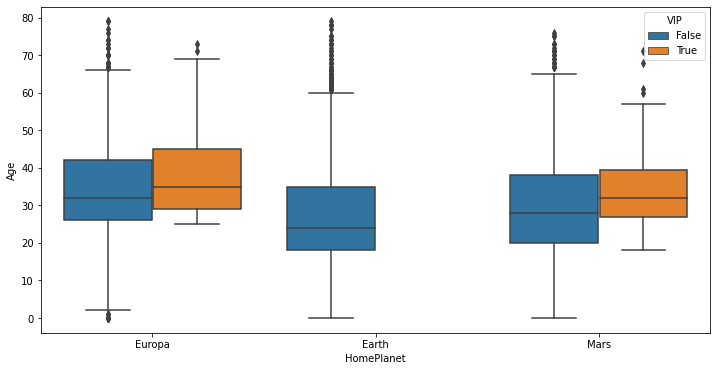

In [17]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df2,x='HomePlanet',y='Age', hue='VIP')

## To impute Age I think we can take VIP and HomePlant columns into account

In [18]:
for i in df2['HomePlanet'].dropna().unique():
    for j in df2['VIP'].dropna().unique():
        print(f'Homeplanet-->{i} and VIP--> {j}')
        print(df2[(df2['HomePlanet']==i) & (df2['VIP']==j)]['Age'].dropna().median())
        print('\n')

Homeplanet-->Europa and VIP--> False
32.0


Homeplanet-->Europa and VIP--> True
35.0


Homeplanet-->Earth and VIP--> False
24.0


Homeplanet-->Earth and VIP--> True
nan


Homeplanet-->Mars and VIP--> False
28.0


Homeplanet-->Mars and VIP--> True
32.0




In [19]:
df2

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,S


In [20]:
df2['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [21]:
df2

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,S


In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Cabin_Deck    8494 non-null   object 
 12  Cabin_Side    8494 non-null   object 
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB


## Converting each column to its best suited datatype

### CryoSleep and VIP have to be turned bool

In [23]:
df2 = df2.convert_dtypes()

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   string 
 1   CryoSleep     8476 non-null   boolean
 2   Destination   8511 non-null   string 
 3   Age           8514 non-null   Int64  
 4   VIP           8490 non-null   boolean
 5   RoomService   8512 non-null   Int64  
 6   FoodCourt     8510 non-null   Int64  
 7   ShoppingMall  8485 non-null   Int64  
 8   Spa           8510 non-null   Int64  
 9   VRDeck        8505 non-null   Int64  
 10  Transported   8693 non-null   boolean
 11  Cabin_Deck    8494 non-null   string 
 12  Cabin_Side    8494 non-null   string 
dtypes: Int64(6), boolean(3), string(4)
memory usage: 781.1 KB


In [25]:
df2

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side
0,Europa,False,TRAPPIST-1e,39,False,0,0,0,0,0,False,B,P
1,Earth,False,TRAPPIST-1e,24,False,109,9,25,549,44,True,F,S
2,Europa,False,TRAPPIST-1e,58,True,43,3576,0,6715,49,False,A,S
3,Europa,False,TRAPPIST-1e,33,False,0,1283,371,3329,193,False,A,S
4,Earth,False,TRAPPIST-1e,16,False,303,70,151,565,2,True,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41,True,0,6819,0,1643,74,False,A,P
8689,Earth,True,PSO J318.5-22,18,False,0,0,0,0,0,False,G,S
8690,Earth,False,TRAPPIST-1e,26,False,0,0,1872,1,0,True,G,S
8691,Europa,False,55 Cancri e,32,False,0,1049,0,353,3235,False,E,S


<Axes: >

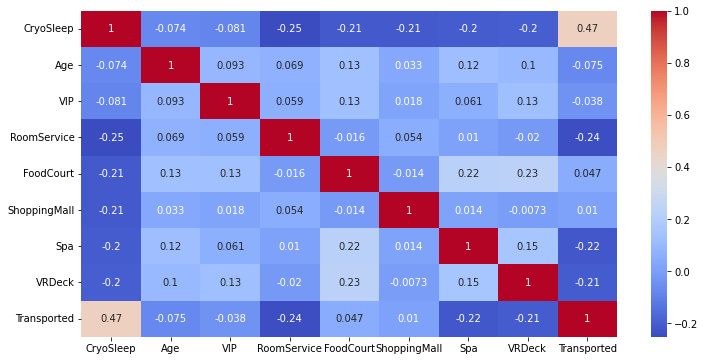

In [26]:
plt.figure(figsize=(12,6))
sns.heatmap(data=df2.corr(), annot=True, cmap='coolwarm')

In [27]:
df2.corr()['Transported'].sort_values(ascending=False)[1:]

CryoSleep       0.468645
FoodCourt       0.046566
ShoppingMall    0.010141
VIP            -0.037650
Age            -0.075026
VRDeck         -0.207075
Spa            -0.221131
RoomService    -0.244611
Name: Transported, dtype: float64

## Seems like cryo sleep and transported have some good correlation but not very high

## Let's fill NA values by 'Missing' for all the categorical columns

In [28]:
df3 = df2.copy()

In [29]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   string 
 1   CryoSleep     8476 non-null   boolean
 2   Destination   8511 non-null   string 
 3   Age           8514 non-null   Int64  
 4   VIP           8490 non-null   boolean
 5   RoomService   8512 non-null   Int64  
 6   FoodCourt     8510 non-null   Int64  
 7   ShoppingMall  8485 non-null   Int64  
 8   Spa           8510 non-null   Int64  
 9   VRDeck        8505 non-null   Int64  
 10  Transported   8693 non-null   boolean
 11  Cabin_Deck    8494 non-null   string 
 12  Cabin_Side    8494 non-null   string 
dtypes: Int64(6), boolean(3), string(4)
memory usage: 781.1 KB


In [30]:
df3.isna().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Cabin_Deck      199
Cabin_Side      199
dtype: int64

In [31]:
for i in df3.select_dtypes(include=['string']).columns:
    print(f" {i} --->  {df3[i].isna().sum()}")
    print(f" {i} --->  {100*df3[i].isna().sum()/len(df3[i])}")

 HomePlanet --->  201
 HomePlanet --->  2.312205222592891
 Destination --->  182
 Destination --->  2.093638559760727
 Cabin_Deck --->  199
 Cabin_Deck --->  2.289198205452663
 Cabin_Side --->  199
 Cabin_Side --->  2.289198205452663


In [32]:
for i in df3.select_dtypes(include=['string']).columns:
    df3[i].fillna('Missing',inplace=True)

In [33]:
df3.isna().sum()

HomePlanet        0
CryoSleep       217
Destination       0
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Cabin_Deck        0
Cabin_Side        0
dtype: int64

### Filled HomePlanted, Destination, Cabin_Deck

In [34]:
#df.isna().sum()

<Axes: xlabel='HomePlanet', ylabel='Age'>

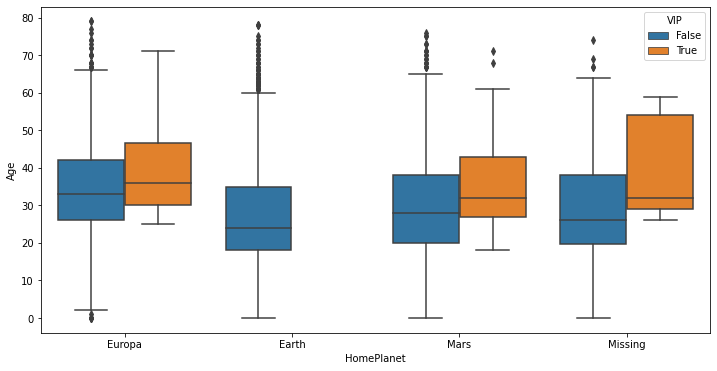

In [35]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3.dropna(),x='HomePlanet',y='Age',hue='VIP')

In [36]:
df3['VIP'].unique()

<BooleanArray>
[False, True, <NA>]
Length: 3, dtype: boolean

In [37]:
df3[pd.isnull(df3['VIP'])==True]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side
38,Earth,False,55 Cancri e,15,<NA>,0,492,48,20,401,False,F,S
102,Earth,False,TRAPPIST-1e,0,<NA>,0,0,0,0,0,True,G,S
145,Mars,True,TRAPPIST-1e,35,<NA>,0,0,0,0,0,True,F,P
228,Mars,True,55 Cancri e,14,<NA>,0,0,0,0,0,True,F,S
566,Mars,False,TRAPPIST-1e,<NA>,<NA>,43,152,182,1,2005,False,D,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8494,Earth,True,TRAPPIST-1e,0,<NA>,0,0,<NA>,0,0,True,G,S
8512,Earth,False,PSO J318.5-22,16,<NA>,0,0,761,0,0,False,F,P
8542,Earth,True,55 Cancri e,55,<NA>,0,0,0,0,0,False,G,S
8630,Europa,True,TRAPPIST-1e,52,<NA>,0,0,0,0,0,True,B,P


In [38]:
df3['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: Int64

In [39]:
df3['VIP'].isna().sum()

203

In [40]:
#### Let's

In [41]:
df3['Total_Bill'] = df3['RoomService'] + df3['FoodCourt'] + df3['ShoppingMall'] + df3['Spa'] + df3['VRDeck']

In [42]:
df3

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side,Total_Bill
0,Europa,False,TRAPPIST-1e,39,False,0,0,0,0,0,False,B,P,0
1,Earth,False,TRAPPIST-1e,24,False,109,9,25,549,44,True,F,S,736
2,Europa,False,TRAPPIST-1e,58,True,43,3576,0,6715,49,False,A,S,10383
3,Europa,False,TRAPPIST-1e,33,False,0,1283,371,3329,193,False,A,S,5176
4,Earth,False,TRAPPIST-1e,16,False,303,70,151,565,2,True,F,S,1091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41,True,0,6819,0,1643,74,False,A,P,8536
8689,Earth,True,PSO J318.5-22,18,False,0,0,0,0,0,False,G,S,0
8690,Earth,False,TRAPPIST-1e,26,False,0,0,1872,1,0,True,G,S,1873
8691,Europa,False,55 Cancri e,32,False,0,1049,0,353,3235,False,E,S,4637


<Figure size 864x432 with 0 Axes>

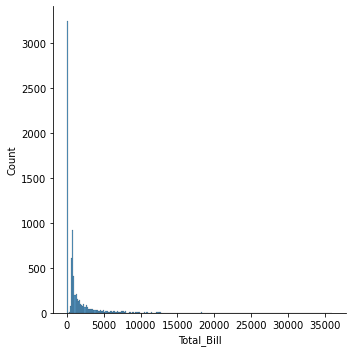

In [43]:
plt.figure(figsize=(12,6))
sns.displot(df3,x='Total_Bill')

In [44]:
df3['Total_Bill'].describe()

count     7785.000000
mean      1484.601541
std       2845.288241
min          0.000000
25%          0.000000
50%        736.000000
75%       1486.000000
max      35987.000000
Name: Total_Bill, dtype: float64

### Total Bill is highly right skewed

In [45]:
df3['Total_Bill_Log'] = np.log(df3['Total_Bill'])

<Axes: ylabel='Frequency'>

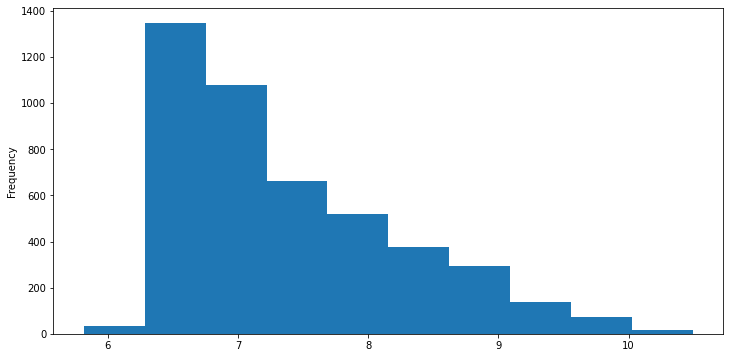

In [46]:
df3[~df3.isin([np.nan, np.inf, -np.inf]).any(1)]['Total_Bill_Log'].plot(kind='hist',figsize=(12,6))

### We won't be using Log Total Bill in the final model as it contains 'inf' values

In [47]:
np.linspace(df3['Total_Bill'].min() , df3['Total_Bill'].max(),6)

array([    0. ,  7197.4, 14394.8, 21592.2, 28789.6, 35987. ])

In [48]:
df3['Total_Bill'].value_counts().head(20)

0       3247
809       50
788       39
804       36
803       34
908       32
907       30
791       29
888       24
716       24
1298      24
787       23
810       21
808       20
2598      19
704       18
717       18
703       18
1299      17
724       16
Name: Total_Bill, dtype: Int64

In [49]:
df3[df3['VIP']==True]['Total_Bill'].value_counts().head(20)

0        24
1298      2
6608      2
2005      2
1048      2
4841      2
861       2
3015      1
3014      1
1820      1
1227      1
6784      1
25400     1
1056      1
779       1
831       1
5043      1
6634      1
9766      1
2689      1
Name: Total_Bill, dtype: Int64

In [50]:
df3.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported',
       'Cabin_Deck', 'Cabin_Side', 'Total_Bill', 'Total_Bill_Log'],
      dtype='object')



RoomService
VIP TRUE


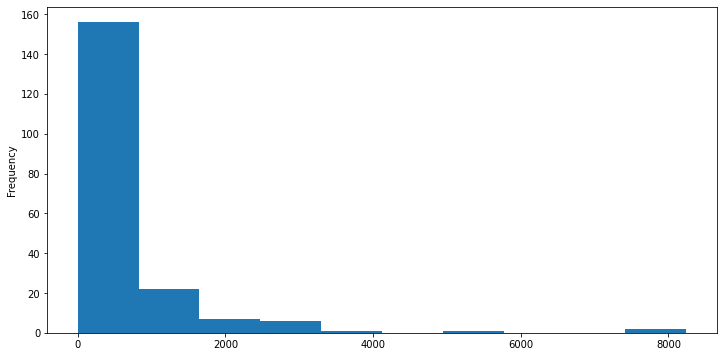

VIP FALSE


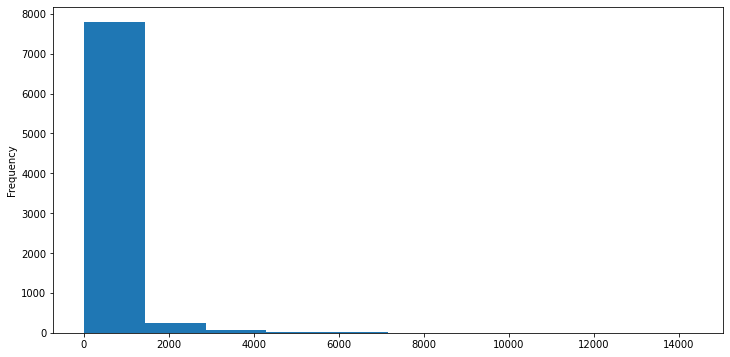



FoodCourt
VIP TRUE


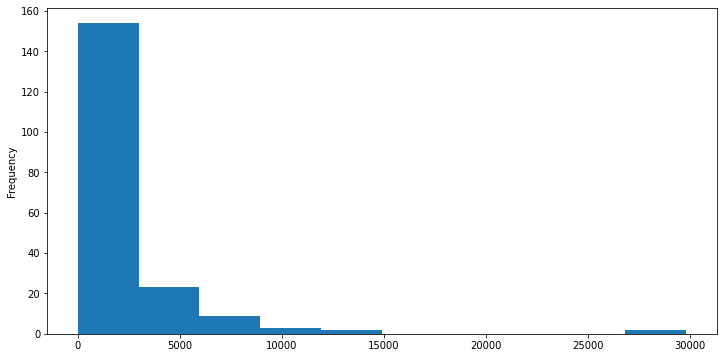

VIP FALSE


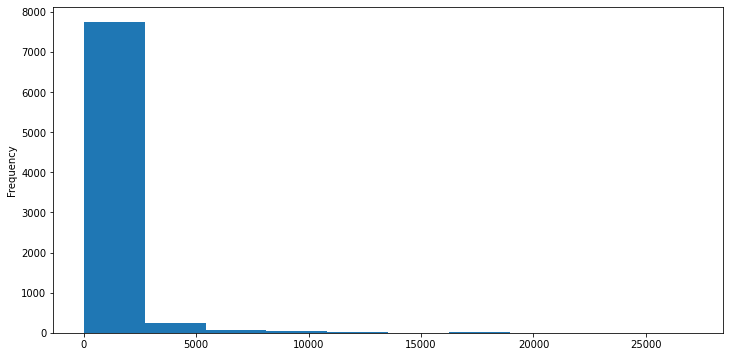



ShoppingMall
VIP TRUE


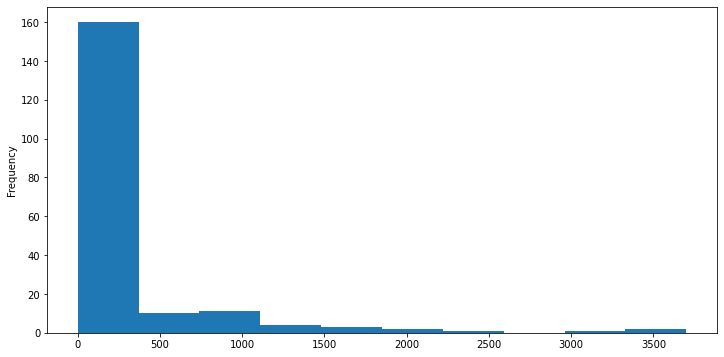

VIP FALSE


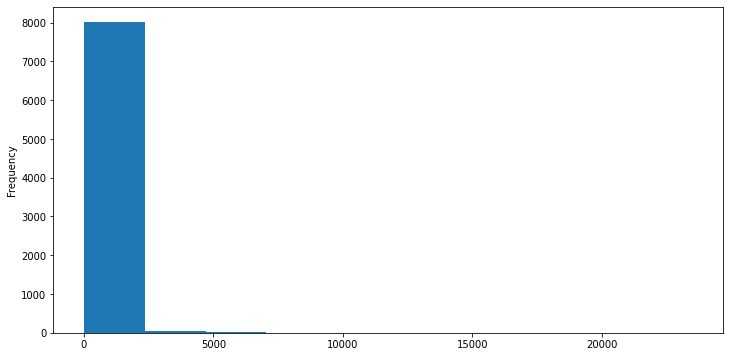



Spa
VIP TRUE


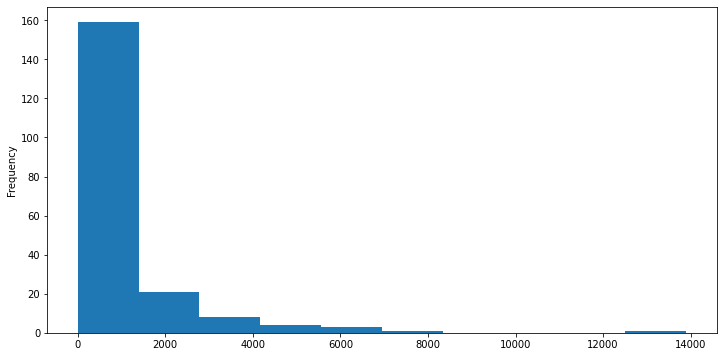

VIP FALSE


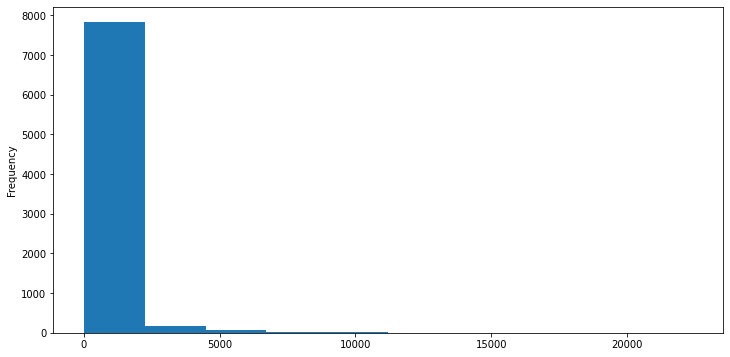



VRDeck
VIP TRUE


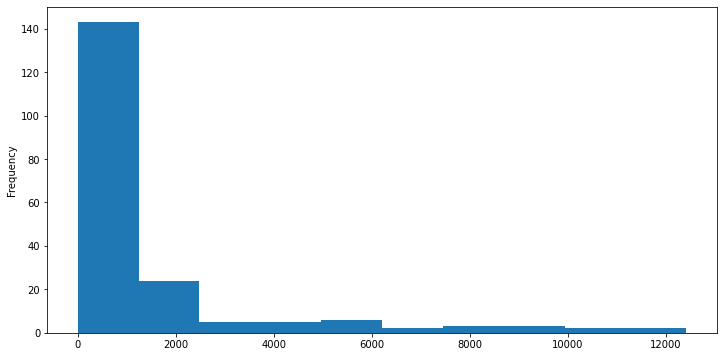

VIP FALSE


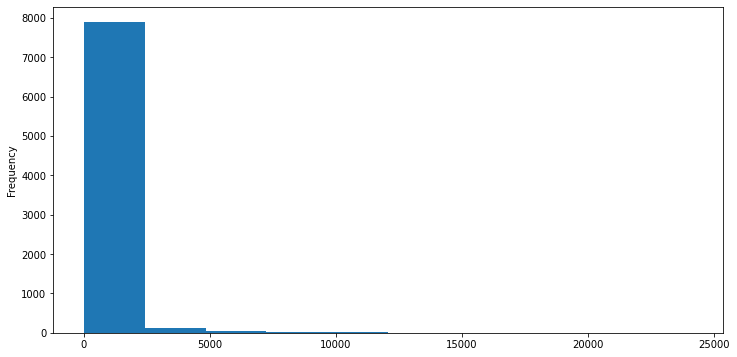



Total_Bill
VIP TRUE


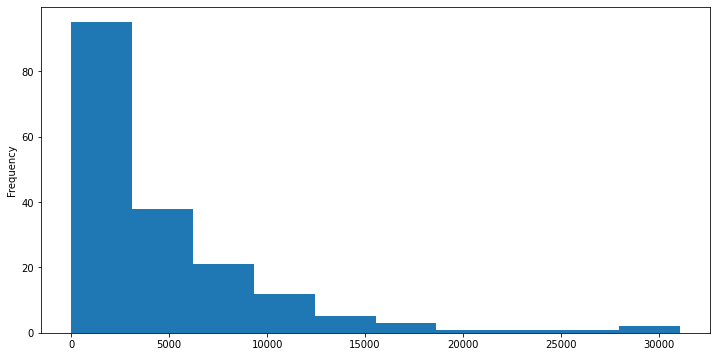

VIP FALSE


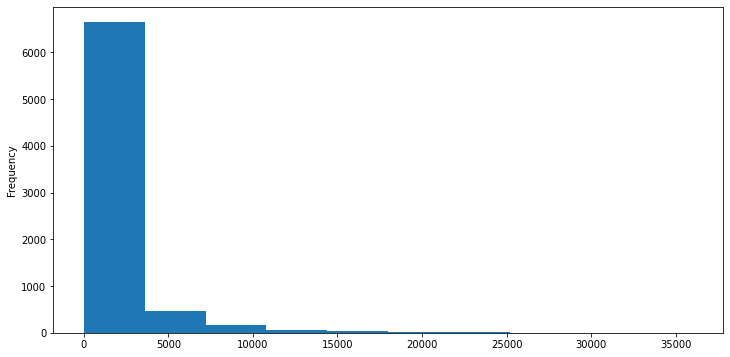

In [51]:
for i in ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Total_Bill']:
    print('\n')
    print(i)
    print('VIP TRUE')
    df3[df3['VIP']==True][i].plot(kind='hist',figsize=(12,6))
    plt.show()
    print('VIP FALSE')
    df3[df3['VIP']==False][i].plot(kind='hist',figsize=(12,6))
    plt.show();

### Not a lot of difference between VIP=TRUE and VIP=FALSE, We will fillna in VIP by False. Because if we replace it by True then we will notice that the median age of all the VIPs from Earth (missing value is mostly from Earth) will be lower than that of Non VIPs

In [52]:
df3['VIP'].fillna(False).value_counts()

False    8494
True      199
Name: VIP, dtype: Int64

In [53]:
df3['VIP'].fillna(False,inplace=True)

In [54]:
df3.isna().sum()

HomePlanet          0
CryoSleep         217
Destination         0
Age               179
VIP                 0
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Transported         0
Cabin_Deck          0
Cabin_Side          0
Total_Bill        908
Total_Bill_Log    908
dtype: int64

### Filled VIP

### Now let's fill Age

<Axes: xlabel='HomePlanet', ylabel='Age'>

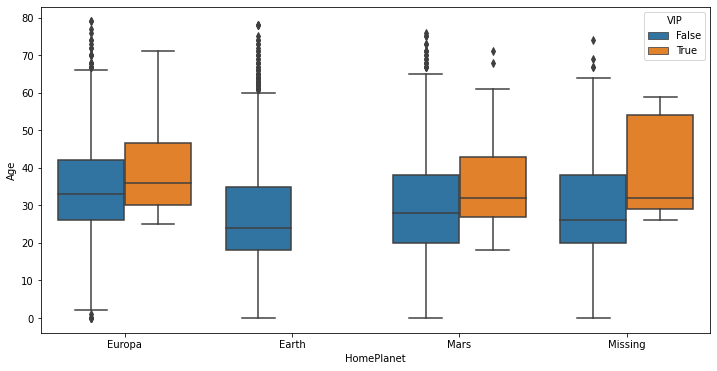

In [55]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3.dropna(),x='HomePlanet',y='Age',hue='VIP')

In [56]:
df3.isna().sum()

HomePlanet          0
CryoSleep         217
Destination         0
Age               179
VIP                 0
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Transported         0
Cabin_Deck          0
Cabin_Side          0
Total_Bill        908
Total_Bill_Log    908
dtype: int64

In [57]:
for i in df3['HomePlanet'].unique():
    for j in df3['VIP'].unique():
        print(f"Homeplanet--->{i} & VIP--> {j}")
        print(df3[(df3['HomePlanet']==i) & (df3['VIP']==j)]['Age'].dropna().median())

Homeplanet--->Europa & VIP--> False
32.0
Homeplanet--->Europa & VIP--> True
35.0
Homeplanet--->Earth & VIP--> False
23.0
Homeplanet--->Earth & VIP--> True
<NA>
Homeplanet--->Mars & VIP--> False
28.0
Homeplanet--->Mars & VIP--> True
32.0
Homeplanet--->Missing & VIP--> False
26.0
Homeplanet--->Missing & VIP--> True
32.0


In [58]:
def Age_Imputer(cols):
    hp = cols[0]
    vip = cols[1]
    age = cols[2]
    if pd.isnull(age):
        if (hp=='Europa') & (vip==False):
            age=32
        elif (hp=='Europa') & (vip==True):
            age=35
        elif (hp=='Earth') & (vip==False):
            age=23
        elif (hp=='Earth') & (vip==True):
            age=23
        elif (hp=='Mars') & (vip==False):
            age=28
        elif (hp=='Mars') & (vip==True):
            age=32
        elif (hp=='Missing') & (vip==False):
            age=26
        elif (hp=='Missing') & (vip==True):
            age=32
        return age
    else:
        return age

In [59]:
df3['Age'] = df3[['HomePlanet','VIP','Age']].apply(Age_Imputer,axis=1)

<Figure size 864x432 with 0 Axes>

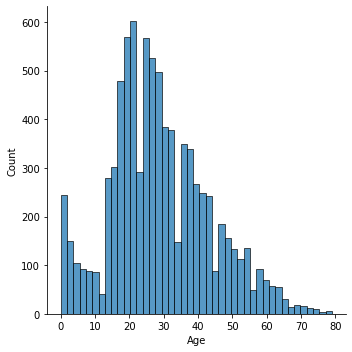

In [60]:
plt.figure(figsize=(12,6))
sns.displot(df2,x='Age')

<Figure size 864x432 with 0 Axes>

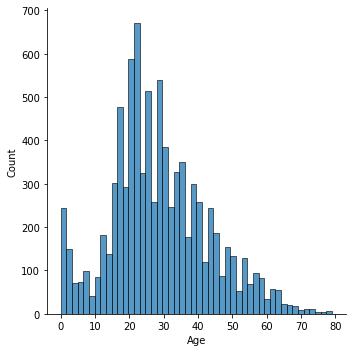

In [61]:
plt.figure(figsize=(12,6))
sns.displot(df3,x='Age')

### Distribution remains more or less the same. Good imputation

### Age Imputed

### Now let's impute cryosleep

In [62]:
df3.isna().sum()

HomePlanet          0
CryoSleep         217
Destination         0
Age                 0
VIP                 0
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Transported         0
Cabin_Deck          0
Cabin_Side          0
Total_Bill        908
Total_Bill_Log    908
dtype: int64

In [63]:
df3['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: Int64

In [64]:
100 * df3['CryoSleep'].value_counts()/len(df3['CryoSleep'])

False    62.567583
True     34.936156
Name: CryoSleep, dtype: Float64



RoomService
CryoSleep TRUE


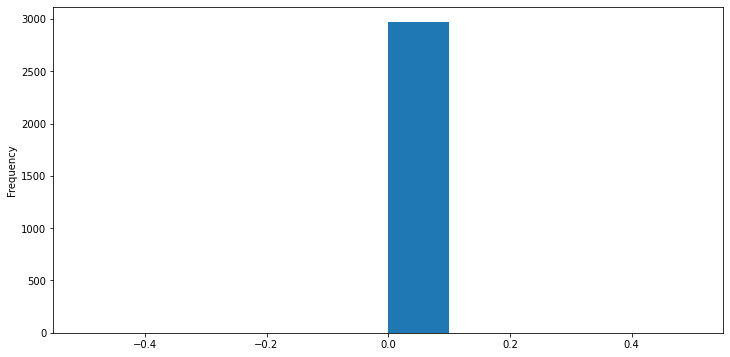

CryoSleep FALSE


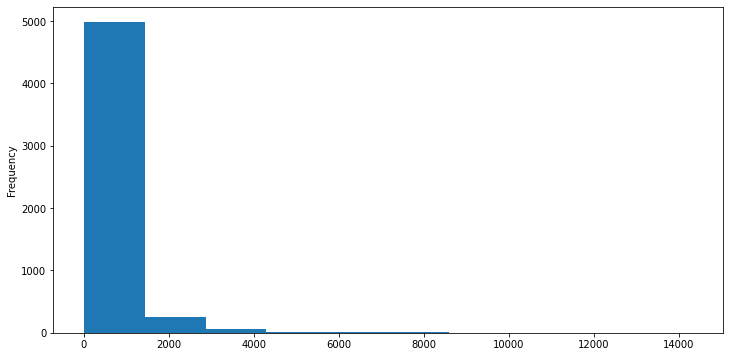



FoodCourt
CryoSleep TRUE


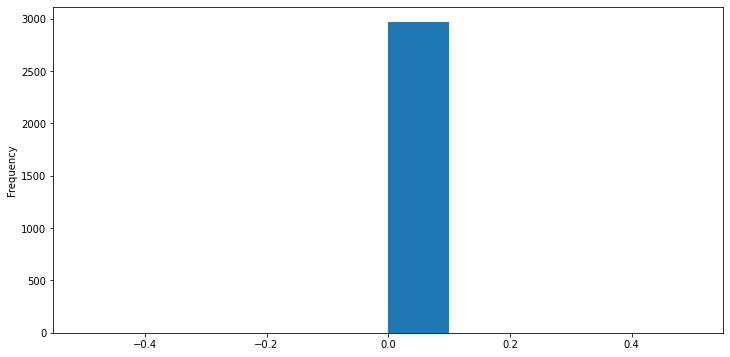

CryoSleep FALSE


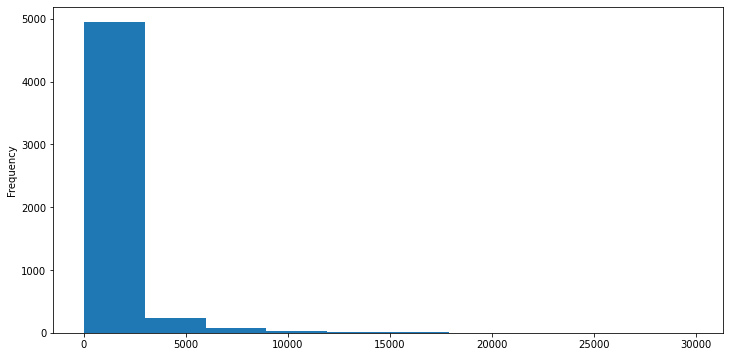



ShoppingMall
CryoSleep TRUE


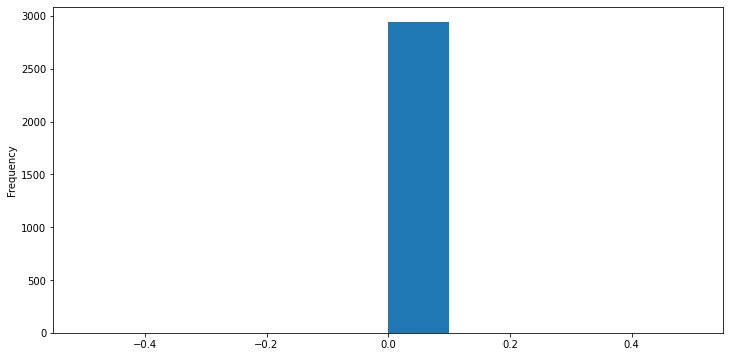

CryoSleep FALSE


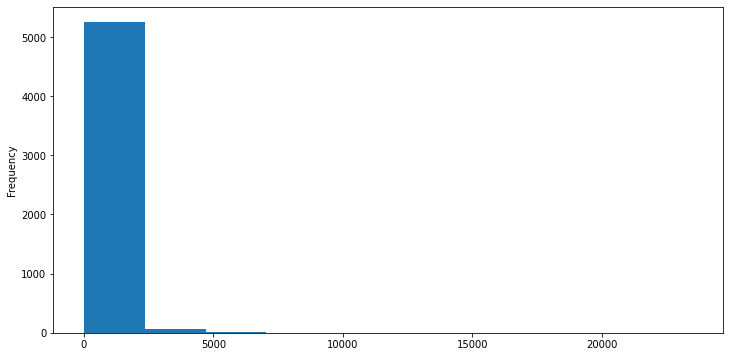



Spa
CryoSleep TRUE


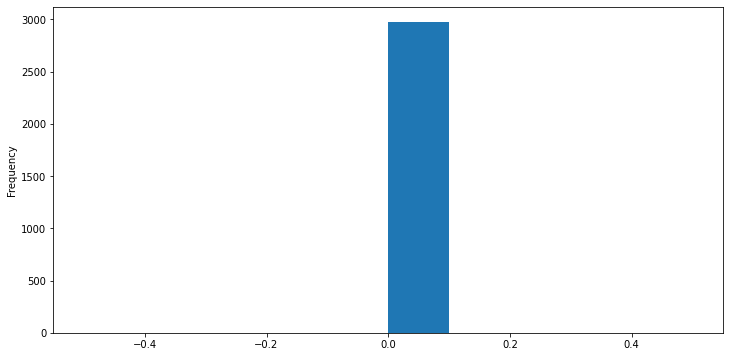

CryoSleep FALSE


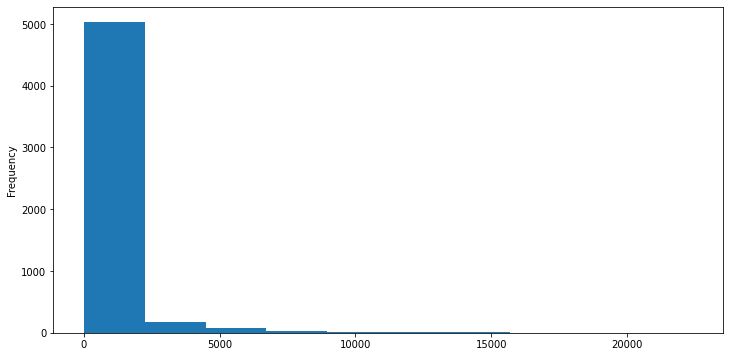



VRDeck
CryoSleep TRUE


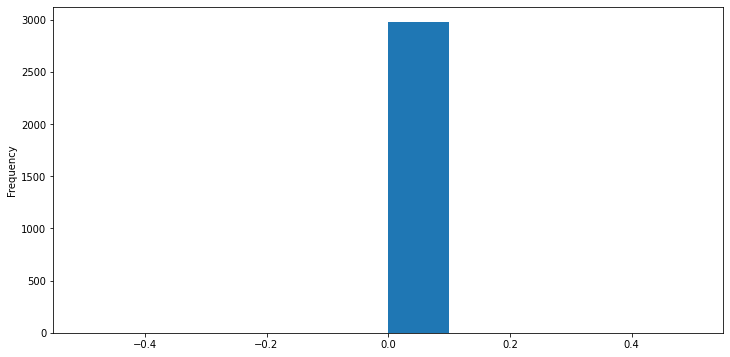

CryoSleep FALSE


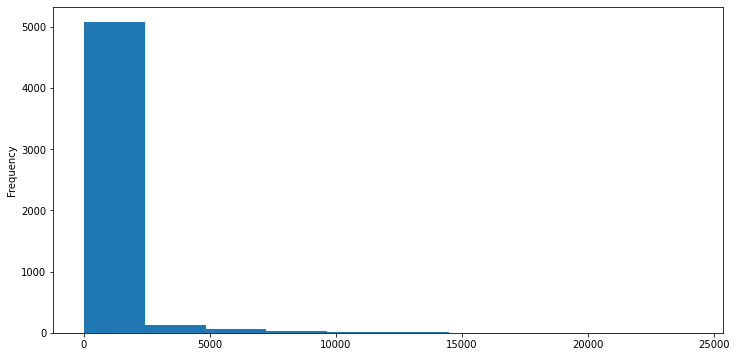



Total_Bill
CryoSleep TRUE


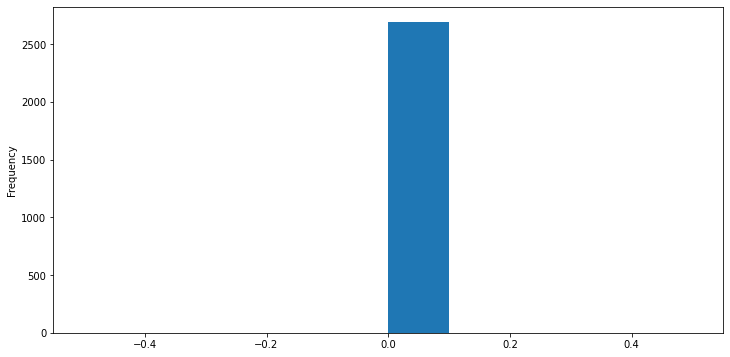

CryoSleep FALSE


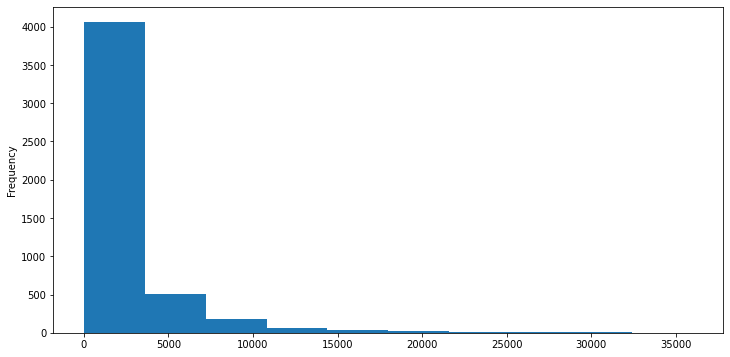

In [65]:
for i in ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Total_Bill']:
    print('\n')
    print(i)
    print('CryoSleep TRUE')
    df3[df3['CryoSleep']==True][i].plot(kind='hist',figsize=(12,6))
    plt.show()
    print('CryoSleep FALSE')
    df3[df3['CryoSleep']==False][i].plot(kind='hist',figsize=(12,6))
    plt.show();

### It makes sense, thjose who were in Cryosleep couldn;t do any purchases. Hence their bill was 0.

In [66]:
df3[(pd.isnull(df3['CryoSleep'])==True) & (pd.isnull(df3['Total_Bill'])==True)]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side,Total_Bill,Total_Bill_Log
111,Mars,<NA>,TRAPPIST-1e,26,False,0,0,0,0,<NA>,True,F,P,<NA>,<NA>
1531,Earth,<NA>,TRAPPIST-1e,4,False,0,0,0,0,<NA>,True,G,S,<NA>,<NA>
2134,Earth,<NA>,55 Cancri e,6,False,0,0,0,<NA>,0,False,G,S,<NA>,<NA>
2231,Earth,<NA>,TRAPPIST-1e,24,False,0,0,<NA>,59,4120,False,G,P,<NA>,<NA>
2402,Earth,<NA>,PSO J318.5-22,21,False,0,0,<NA>,0,0,False,G,P,<NA>,<NA>
2639,Earth,<NA>,TRAPPIST-1e,5,False,0,0,0,0,<NA>,False,G,S,<NA>,<NA>
3072,Earth,<NA>,TRAPPIST-1e,15,False,10,0,99,<NA>,2031,False,F,S,<NA>,<NA>
3232,Earth,<NA>,55 Cancri e,4,False,0,<NA>,0,0,0,True,G,P,<NA>,<NA>
3850,Europa,<NA>,TRAPPIST-1e,23,False,0,0,0,0,<NA>,True,B,P,<NA>,<NA>
4129,Earth,<NA>,TRAPPIST-1e,38,False,<NA>,2,404,121,0,False,G,P,<NA>,<NA>


In [67]:
def Cryosleep_Imputer(cols):
    tb = cols[0]
    cp = cols[1]
    if pd.isnull(cp):
        if pd.isnull(tb)==False:
            if tb > 0:
                cp = False
            else:
                cp=True
        else:
            cp = False # as False is the majority and there are only 24 such cases
        
        return cp
    else:
        return cp

In [68]:
df3['CryoSleep'] = df3[['Total_Bill','CryoSleep']].apply(Cryosleep_Imputer,axis=1)

In [69]:
df2['CryoSleep']

0       False
1       False
2       False
3       False
4       False
        ...  
8688    False
8689     True
8690    False
8691    False
8692    False
Name: CryoSleep, Length: 8693, dtype: boolean

In [70]:
df3['CryoSleep']

0       0
1       0
2       0
3       0
4       0
       ..
8688    0
8689    1
8690    0
8691    0
8692    0
Name: CryoSleep, Length: 8693, dtype: object

In [71]:
df3.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Transported         0
Cabin_Deck          0
Cabin_Side          0
Total_Bill        908
Total_Bill_Log    908
dtype: int64

In [72]:
df3['CryoSleep'].value_counts()

0    5569
1    3124
Name: CryoSleep, dtype: int64

In [73]:
df2['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: Int64

### Cryosleep imputed

### Now we can use Cryosleep (if cryosleeep=0 all the bils would be 0), Homeplanet and VIP to impute all the numeric columns

In [74]:
df3

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side,Total_Bill,Total_Bill_Log
0,Europa,0,TRAPPIST-1e,39,False,0,0,0,0,0,False,B,P,0,-inf
1,Earth,0,TRAPPIST-1e,24,False,109,9,25,549,44,True,F,S,736,6.60123
2,Europa,0,TRAPPIST-1e,58,True,43,3576,0,6715,49,False,A,S,10383,9.247925
3,Europa,0,TRAPPIST-1e,33,False,0,1283,371,3329,193,False,A,S,5176,8.551788
4,Earth,0,TRAPPIST-1e,16,False,303,70,151,565,2,True,F,S,1091,6.99485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,55 Cancri e,41,True,0,6819,0,1643,74,False,A,P,8536,9.052048
8689,Earth,1,PSO J318.5-22,18,False,0,0,0,0,0,False,G,S,0,-inf
8690,Earth,0,TRAPPIST-1e,26,False,0,0,1872,1,0,True,G,S,1873,7.535297
8691,Europa,0,55 Cancri e,32,False,0,1049,0,353,3235,False,E,S,4637,8.441823


In [75]:
df3[df3['CryoSleep']==1]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side,Total_Bill,Total_Bill_Log
7,Earth,1,TRAPPIST-1e,28,False,0,0,0,0,<NA>,True,G,S,<NA>,<NA>
9,Europa,1,55 Cancri e,14,False,0,0,0,0,0,True,B,P,0,-inf
10,Europa,1,TRAPPIST-1e,34,False,0,0,<NA>,0,0,True,B,P,<NA>,<NA>
18,Mars,1,TRAPPIST-1e,45,False,0,0,0,0,0,True,F,P,0,-inf
21,Earth,1,TRAPPIST-1e,1,False,0,0,0,0,0,False,E,S,0,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8679,Europa,1,TRAPPIST-1e,20,False,0,0,0,0,0,True,E,S,0,-inf
8680,Earth,1,TRAPPIST-1e,31,False,0,0,0,0,0,True,G,P,0,-inf
8681,Earth,1,55 Cancri e,33,False,0,0,0,0,0,True,G,S,0,-inf
8684,Missing,1,TRAPPIST-1e,23,False,0,0,0,0,0,True,G,P,0,-inf


### Imputing RoomService

In [76]:
for i in df3['HomePlanet'].unique():
    for j in df3['VIP'].unique():
        print(f"Planet --> {i} and VIP ---> {j}")
        print(df3[(df3['CryoSleep']==False) & (df3['HomePlanet']==i) & (df3['VIP']==j)]['RoomService'].median())

Planet --> Europa and VIP ---> False
0.0
Planet --> Europa and VIP ---> True
0.0
Planet --> Earth and VIP ---> False
1.0
Planet --> Earth and VIP ---> True
<NA>
Planet --> Mars and VIP ---> False
665.0
Planet --> Mars and VIP ---> True
661.0
Planet --> Missing and VIP ---> False
0.0
Planet --> Missing and VIP ---> True
1394.0


In [77]:
def RoomService_Imputer(cols):
    cp = cols[0]
    hp = cols[1]
    vip = cols[2]
    rs = cols[3]
    if pd.isnull(rs):
        if cp==1:
            rs = 0
        else:
            if (hp=='Europa') & (vip==False):
                rs=0
            elif (hp=='Europa') & (vip==True):
                rs=0
            elif (hp=='Earth') & (vip==False):
                rs=1
            elif (hp=='Earth') & (vip==True):
                rs=1 
            elif (hp=='Mars') & (vip==False):
                rs=665  
            elif (hp=='Mars') & (vip==True):
                rs=661
            elif (hp=='Missing') & (vip==False):
                rs=0
            elif (hp=='Missing') & (vip==True):
                rs=1394
        return rs
    else:     
        return rs

In [78]:
df3['RoomService'] = df3[['CryoSleep','HomePlanet', 'VIP', 'RoomService']].apply(RoomService_Imputer, axis=1)

In [79]:
df3.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Transported         0
Cabin_Deck          0
Cabin_Side          0
Total_Bill        908
Total_Bill_Log    908
dtype: int64

<Axes: ylabel='Frequency'>

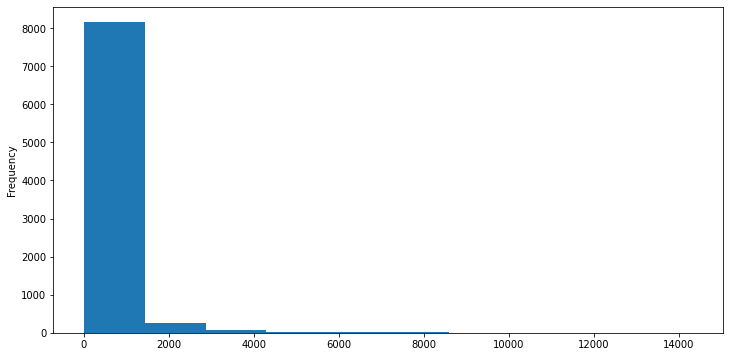

In [80]:
df2['RoomService'].plot(kind='hist',figsize=(12,6))

<Axes: ylabel='Frequency'>

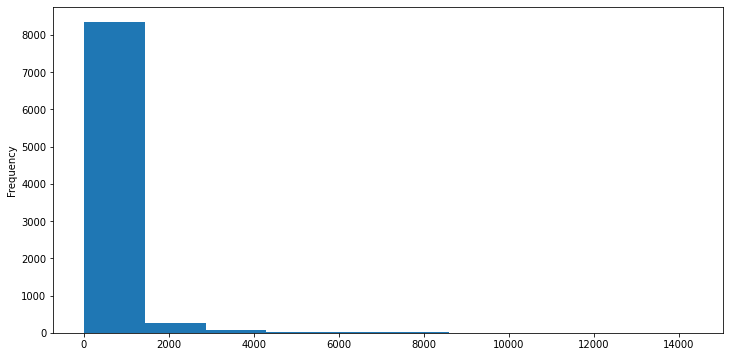

In [81]:
df3['RoomService'].plot(kind='hist',figsize=(12,6))

### The distribution remains more or less the same. Good imputation.
### RoomService Imputed

### Imputing FoodCourt

In [82]:
df3[df3['CryoSleep']==0]['Destination'].value_counts()

TRAPPIST-1e      3988
55 Cancri e      1044
PSO J318.5-22     405
Missing           132
Name: Destination, dtype: Int64

In [83]:
df3['FoodCourt']

0          0
1          9
2       3576
3       1283
4         70
        ... 
8688    6819
8689       0
8690       0
8691    1049
8692    4688
Name: FoodCourt, Length: 8693, dtype: Int64

In [84]:
df3.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported',
       'Cabin_Deck', 'Cabin_Side', 'Total_Bill', 'Total_Bill_Log'],
      dtype='object')

<Axes: xlabel='Cabin_Side', ylabel='FoodCourt'>

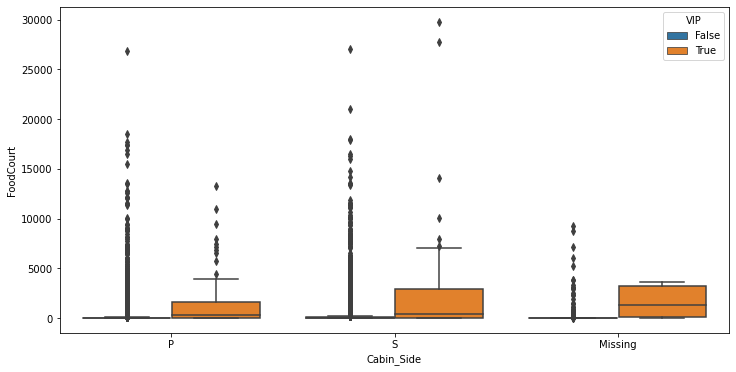

In [85]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3 , x='Cabin_Side', y='FoodCourt', hue='VIP')

<Axes: xlabel='HomePlanet', ylabel='FoodCourt'>

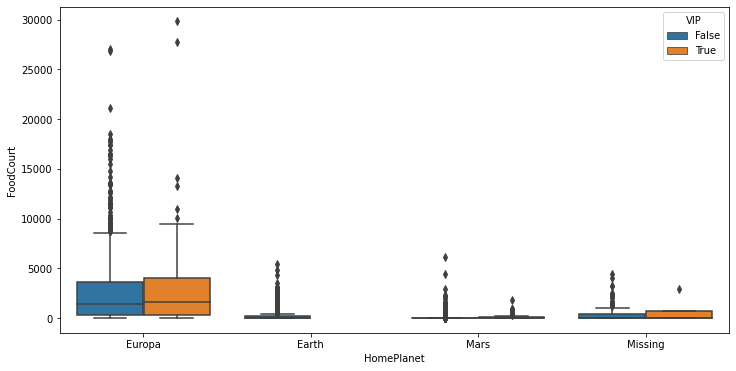

In [86]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3[df3['CryoSleep']==0] , x='HomePlanet', y='FoodCourt', hue='VIP')

In [87]:
for i in df3['HomePlanet'].unique():
    for j in df3['VIP'].unique():
        print(f"Planet --> {i} and VIP ---> {j}")
        print(df3[(df3['CryoSleep']==False) & (df3['HomePlanet']==i) & (df3['VIP']==j)]['FoodCourt'].median())

Planet --> Europa and VIP ---> False
1390.0
Planet --> Europa and VIP ---> True
1577.0
Planet --> Earth and VIP ---> False
1.0
Planet --> Earth and VIP ---> True
<NA>
Planet --> Mars and VIP ---> False
0.0
Planet --> Mars and VIP ---> True
0.0
Planet --> Missing and VIP ---> False
4.0
Planet --> Missing and VIP ---> True
3.5


In [88]:
def FoodCourt_Imputer(cols):
    cp = cols[0]
    hp = cols[1]
    vip = cols[2]
    fc = cols[3]
    if pd.isnull(fc):
        if cp==1:
            fc = 0
        else:
            if (hp=='Europa') & (vip==False):
                fc=1390
            elif (hp=='Europa') & (vip==True):
                fc=1577
            elif (hp=='Earth') & (vip==False):
                fc=1
            elif (hp=='Earth') & (vip==True):
                fc = 1 
            elif (hp=='Mars') & (vip==False):
                fc=0  
            elif (hp=='Mars') & (vip==True):
                fc=0
            elif (hp=='Missing') & (vip==False):
                fc=4
            elif (hp=='Missing') & (vip==True):
                fc=3.5
        return fc
    else:     
        return fc

In [89]:
df3['FoodCourt'] = df3[['CryoSleep','HomePlanet', 'VIP', 'FoodCourt']].apply(FoodCourt_Imputer, axis=1)

<Axes: ylabel='Frequency'>

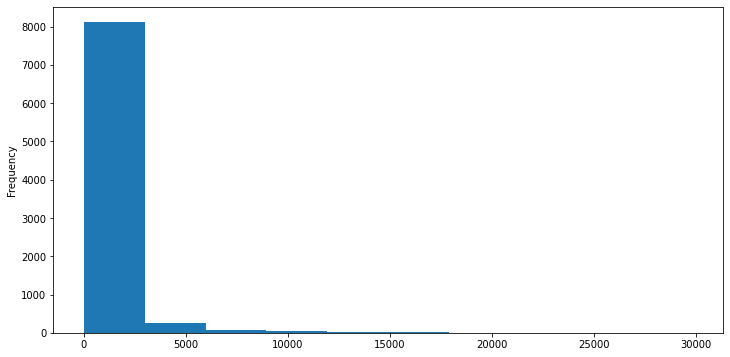

In [90]:
df2['FoodCourt'].plot(kind='hist',figsize=(12,6))

<Axes: ylabel='Frequency'>

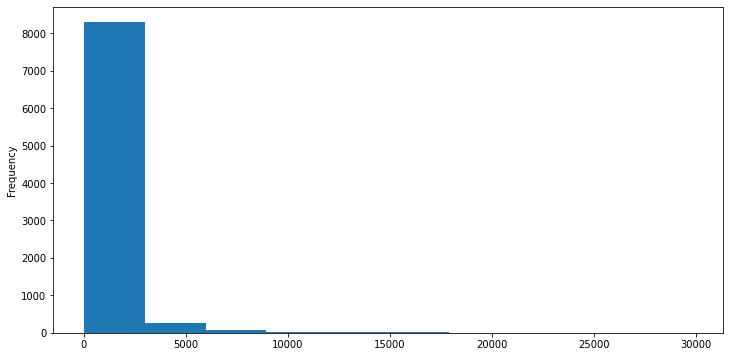

In [91]:
df3['FoodCourt'].plot(kind='hist',figsize=(12,6))

In [92]:
df3.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall      208
Spa               183
VRDeck            188
Transported         0
Cabin_Deck          0
Cabin_Side          0
Total_Bill        908
Total_Bill_Log    908
dtype: int64

### FoodCourt Imputed

### Imputing ShoppingMall

<Axes: xlabel='HomePlanet', ylabel='ShoppingMall'>

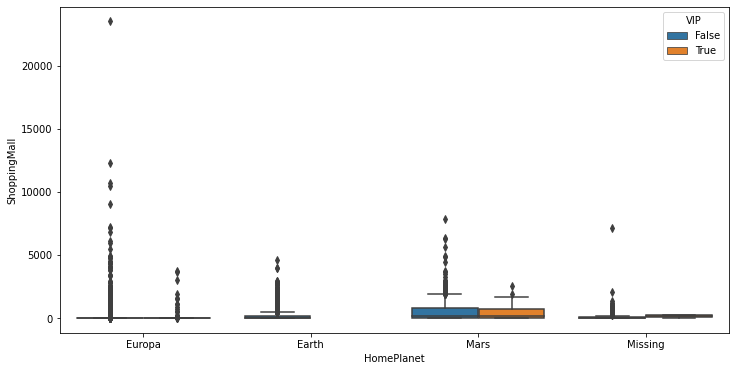

In [93]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3[df3['CryoSleep']==0] , x='HomePlanet', y='ShoppingMall', hue='VIP')

In [94]:
for i in df3['HomePlanet'].unique():
    for j in df3['VIP'].unique():
        print(f"Planet --> {i} and VIP ---> {j}")
        print(df3[(df3['CryoSleep']==False) & (df3['HomePlanet']==i) & (df3['VIP']==j)]['ShoppingMall'].median())

Planet --> Europa and VIP ---> False
0.0
Planet --> Europa and VIP ---> True
0.0
Planet --> Earth and VIP ---> False
1.0
Planet --> Earth and VIP ---> True
<NA>
Planet --> Mars and VIP ---> False
161.0
Planet --> Mars and VIP ---> True
177.0
Planet --> Missing and VIP ---> False
0.0
Planet --> Missing and VIP ---> True
172.5


In [95]:
def ShoppingMall_Imputer(cols):
    cp = cols[0]
    hp = cols[1]
    vip = cols[2]
    sm = cols[3]
    if pd.isnull(sm):
        if cp==1:
            sm = 0
        else:
            if (hp=='Europa') & (vip==False):
                sm=0
            elif (hp=='Europa') & (vip==True):
                sm=0
            elif (hp=='Earth') & (vip==False):
                sm=1
            elif (hp=='Earth') & (vip==True):
                sm = 1 
            elif (hp=='Mars') & (vip==False):
                sm=161  
            elif (hp=='Mars') & (vip==True):
                sm=177
            elif (hp=='Missing') & (vip==False):
                sm=0
            elif (hp=='Missing') & (vip==True):
                sm=172.5
        return sm
    else:     
        return sm

In [96]:
df3['ShoppingMall'] = df3[['CryoSleep','HomePlanet', 'VIP', 'ShoppingMall']].apply(ShoppingMall_Imputer, axis=1)

<Axes: ylabel='Frequency'>

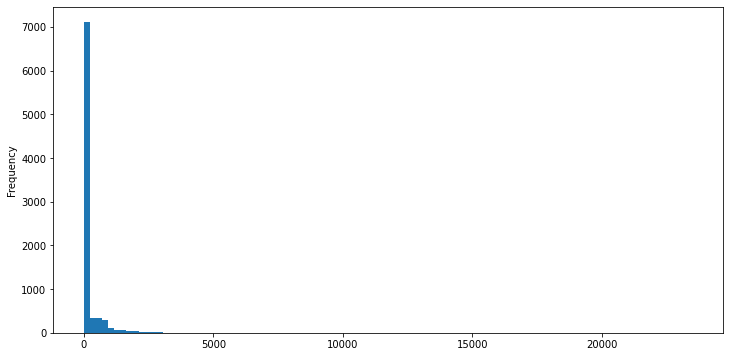

In [97]:
df2['ShoppingMall'].plot(kind='hist',figsize=(12,6), bins=100)

<Axes: ylabel='Frequency'>

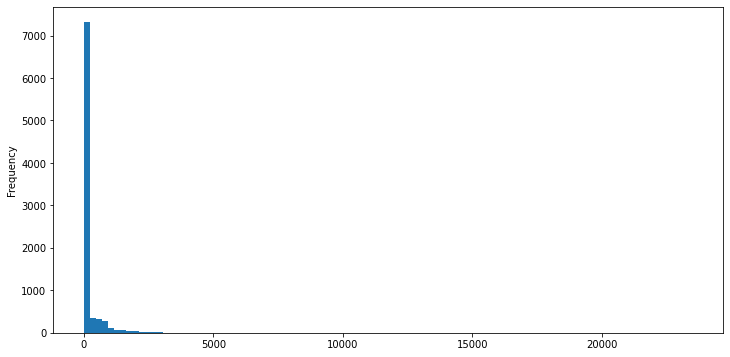

In [98]:
df3['ShoppingMall'].plot(kind='hist',figsize=(12,6),bins=100)

In [99]:
df2['ShoppingMall'].describe()

count     8485.000000
mean       173.729169
std        604.696458
min          0.000000
25%          0.000000
50%          0.000000
75%         27.000000
max      23492.000000
Name: ShoppingMall, dtype: float64

In [100]:
df3['ShoppingMall'].describe()

count     8693.000000
mean       170.008973
std        597.941558
min          0.000000
25%          0.000000
50%          0.000000
75%         23.000000
max      23492.000000
Name: ShoppingMall, dtype: float64

In [101]:
df3.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa               183
VRDeck            188
Transported         0
Cabin_Deck          0
Cabin_Side          0
Total_Bill        908
Total_Bill_Log    908
dtype: int64

### The distribution of ShoppingMall remains more or less the same. Good Imputation
### ShoppingMall Imputed
### Imputing Spa

<Axes: xlabel='HomePlanet', ylabel='Spa'>

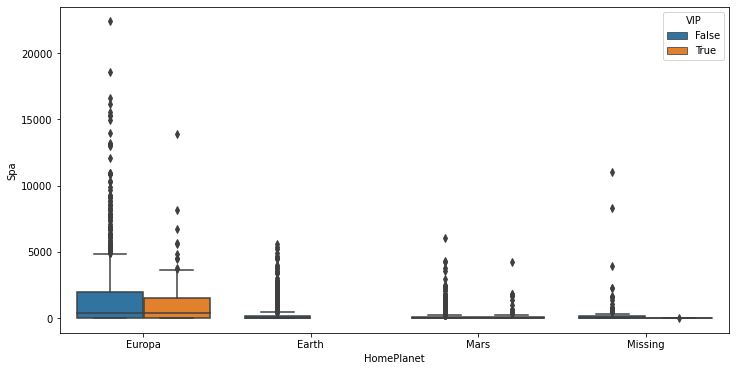

In [102]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3[df3['CryoSleep']==0] , x='HomePlanet', y='Spa', hue='VIP')

<Axes: xlabel='Destination', ylabel='Spa'>

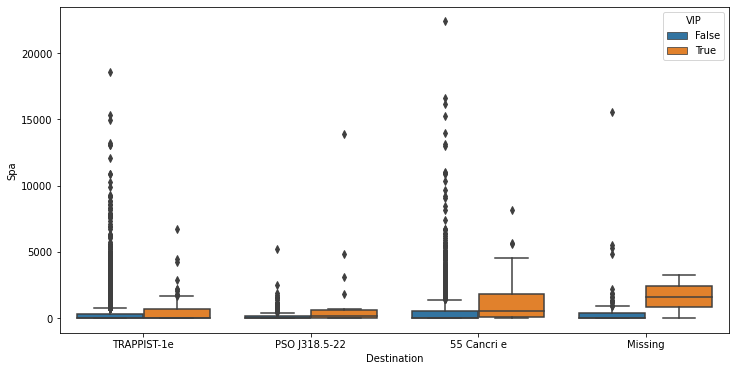

In [103]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3[df3['CryoSleep']==0] , x='Destination', y='Spa', hue='VIP')

<Axes: xlabel='Destination', ylabel='Spa'>

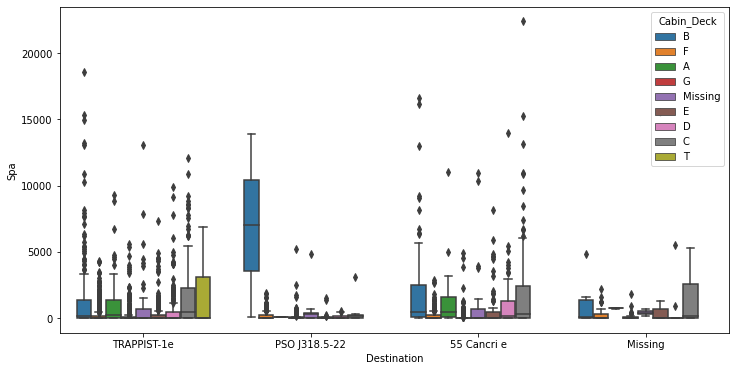

In [104]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3[df3['CryoSleep']==0] , x='Destination', y='Spa', hue='Cabin_Deck')

In [105]:
df3[pd.isnull(df3['Spa'])==True]['Destination'].value_counts()

TRAPPIST-1e      125
55 Cancri e       39
PSO J318.5-22     16
Missing            3
Name: Destination, dtype: Int64

In [106]:
for i in df3['HomePlanet'].unique():
    for j in df3['VIP'].unique():
        print(f"Planet --> {i} and VIP ---> {j}")
        print(df3[(df3['CryoSleep']==False) & (df3['HomePlanet']==i) & (df3['VIP']==j)]['Spa'].median())

Planet --> Europa and VIP ---> False
356.0
Planet --> Europa and VIP ---> True
348.5
Planet --> Earth and VIP ---> False
1.0
Planet --> Earth and VIP ---> True
<NA>
Planet --> Mars and VIP ---> False
0.0
Planet --> Mars and VIP ---> True
0.0
Planet --> Missing and VIP ---> False
7.0
Planet --> Missing and VIP ---> True
0.0


In [107]:
def Spa_Imputer(cols):
    cp = cols[0]
    hp = cols[1]
    vip = cols[2]
    spa = cols[3]
    if pd.isnull(spa):
        if cp==1:
            spa = 0
        else:
            if (hp=='Europa') & (vip==False):
                spa=356
            elif (hp=='Europa') & (vip==True):
                spa=348.5
            elif (hp=='Earth') & (vip==False):
                spa=1
            elif (hp=='Earth') & (vip==True):
                spa = 1 
            elif (hp=='Mars') & (vip==False):
                spa=0  
            elif (hp=='Mars') & (vip==True):
                spa=0
            elif (hp=='Missing') & (vip==False):
                spa=7
            elif (hp=='Missing') & (vip==True):
                spa=0
        return spa
    else:     
        return spa

In [108]:
df3['Spa'] = df3[['CryoSleep','HomePlanet', 'VIP', 'Spa']].apply(Spa_Imputer, axis=1)

In [109]:
df2['Spa'].describe()

count     8510.000000
mean       311.138778
std       1136.705535
min          0.000000
25%          0.000000
50%          0.000000
75%         59.000000
max      22408.000000
Name: Spa, dtype: float64

In [110]:
df3['Spa'].describe()

count     8693.000000
mean       305.539457
std       1125.453592
min          0.000000
25%          0.000000
50%          0.000000
75%         57.000000
max      22408.000000
Name: Spa, dtype: float64

<Axes: ylabel='Frequency'>

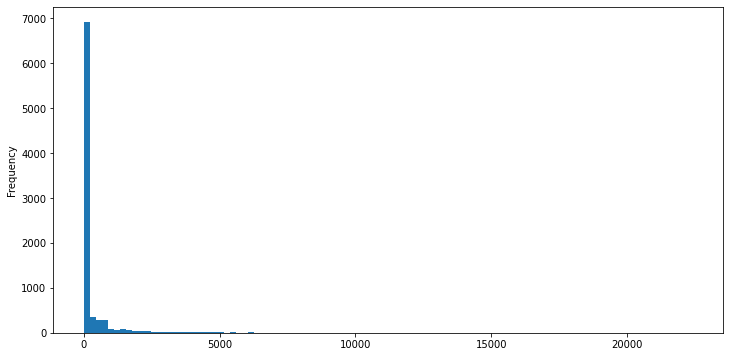

In [111]:
df2['Spa'].plot(kind='hist',figsize=(12,6),bins=100)

<Axes: ylabel='Frequency'>

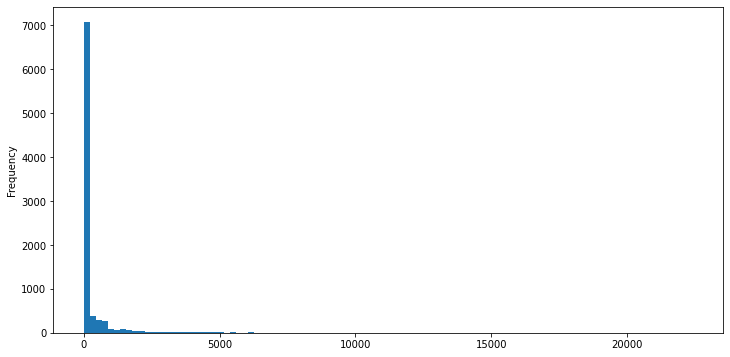

In [112]:
df3['Spa'].plot(kind='hist',figsize=(12,6),bins=100)

In [113]:
df3.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck            188
Transported         0
Cabin_Deck          0
Cabin_Side          0
Total_Bill        908
Total_Bill_Log    908
dtype: int64

### The distribution of Spa remains more or less the same. Good Imputation
### Spa Imputed
### Imputing VRDeck

<Axes: xlabel='HomePlanet', ylabel='VRDeck'>

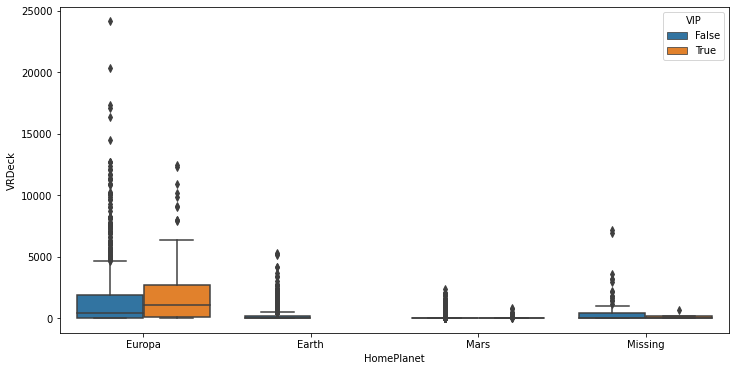

In [114]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3[df3['CryoSleep']==0] , x='HomePlanet', y='VRDeck', hue='VIP')

<Axes: xlabel='HomePlanet', ylabel='VRDeck'>

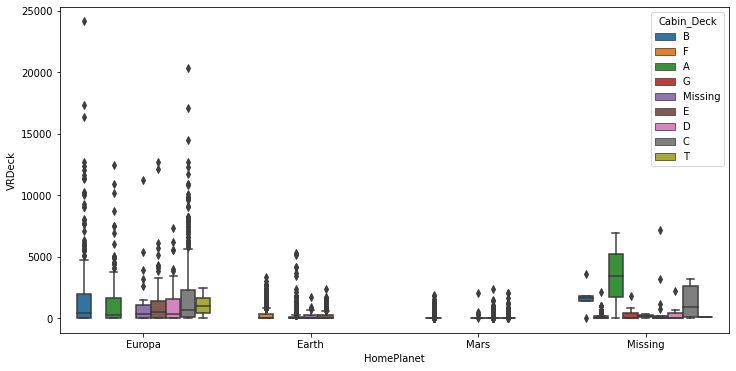

In [115]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3[df3['CryoSleep']==0] , x='HomePlanet', y='VRDeck', hue='Cabin_Deck')

<Axes: xlabel='Destination', ylabel='VRDeck'>

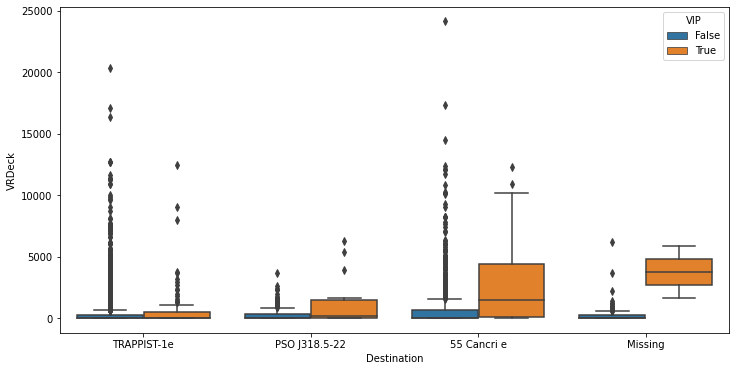

In [116]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3[df3['CryoSleep']==0] , x='Destination', y='VRDeck', hue='VIP')

<Axes: xlabel='Destination', ylabel='VRDeck'>

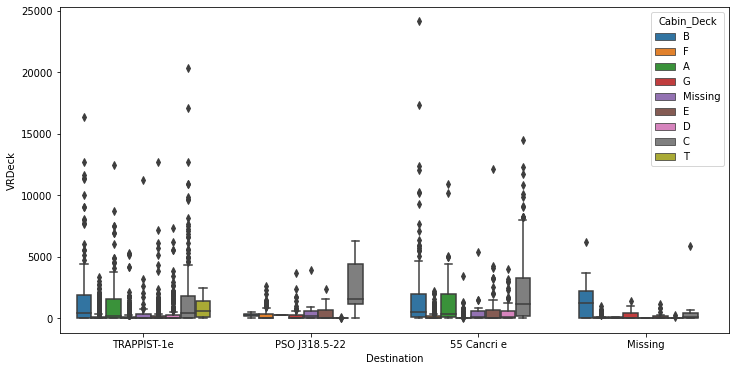

In [117]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3[df3['CryoSleep']==0] , x='Destination', y='VRDeck', hue='Cabin_Deck')

<Axes: xlabel='HomePlanet', ylabel='VRDeck'>

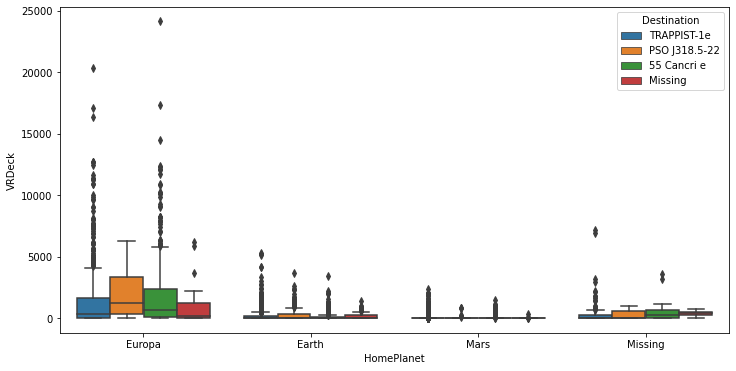

In [118]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df3[df3['CryoSleep']==0] , x='HomePlanet', y='VRDeck', hue='Destination')

In [119]:
df3[pd.isnull(df3['VRDeck'])==True]['HomePlanet'].value_counts()

Earth      111
Mars        39
Europa      37
Missing      1
Name: HomePlanet, dtype: Int64

In [120]:
df3[pd.isnull(df3['VRDeck'])==True]['Destination'].value_counts()

TRAPPIST-1e      134
55 Cancri e       40
PSO J318.5-22     12
Missing            2
Name: Destination, dtype: Int64

In [121]:
df3['VRDeck'].describe()

count     8505.000000
mean       304.854791
std       1145.717189
min          0.000000
25%          0.000000
50%          0.000000
75%         46.000000
max      24133.000000
Name: VRDeck, dtype: float64

In [122]:
for i in df3['HomePlanet'].unique():
    for j in df3['VIP'].unique():
        print(f"Planet --> {i} and VIP ---> {j}")
        print(df3[(df3['CryoSleep']==False) & (df3['HomePlanet']==i) & (df3['VIP']==j)]['VRDeck'].median())

Planet --> Europa and VIP ---> False
402.0
Planet --> Europa and VIP ---> True
1037.0
Planet --> Earth and VIP ---> False
2.0
Planet --> Earth and VIP ---> True
<NA>
Planet --> Mars and VIP ---> False
0.0
Planet --> Mars and VIP ---> True
0.0
Planet --> Missing and VIP ---> False
1.5
Planet --> Missing and VIP ---> True
0.0


In [123]:
def VRDeck_Imputer(cols):
    cp = cols[0]
    hp = cols[1]
    vip = cols[2]
    vr = cols[3]
    if pd.isnull(vr):
        if cp==1:
            vr = 0
        else:
            if (hp=='Europa') & (vip==False):
                vr=402
            elif (hp=='Europa') & (vip==True):
                vr=1037
            elif (hp=='Earth') & (vip==False):
                vr=2
            elif (hp=='Earth') & (vip==True):
                vr = 2 
            elif (hp=='Mars') & (vip==False):
                vr=0  
            elif (hp=='Mars') & (vip==True):
                vr=0
            elif (hp=='Missing') & (vip==False):
                vr=1.5
            elif (hp=='Missing') & (vip==True):
                vr=0
        return vr
    else:     
        return vr

In [124]:
df3['VRDeck'] = df3[['CryoSleep','HomePlanet', 'VIP', 'VRDeck']].apply(VRDeck_Imputer, axis=1)

In [125]:
df2['VRDeck'].describe()

count     8505.000000
mean       304.854791
std       1145.717189
min          0.000000
25%          0.000000
50%          0.000000
75%         46.000000
max      24133.000000
Name: VRDeck, dtype: float64

In [126]:
df3['VRDeck'].describe()

count     8693.000000
mean       299.324859
std       1134.064814
min          0.000000
25%          0.000000
50%          0.000000
75%         42.000000
max      24133.000000
Name: VRDeck, dtype: float64

<Axes: ylabel='Frequency'>

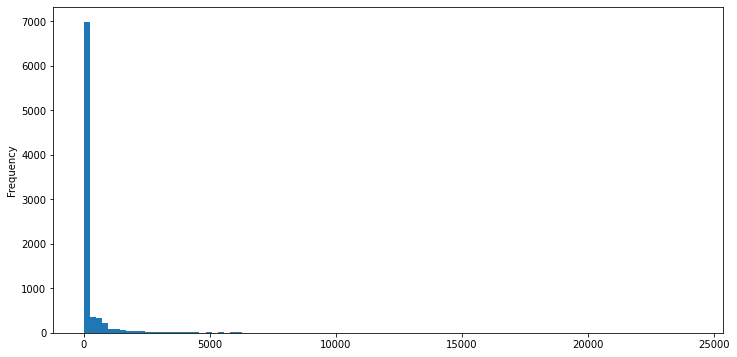

In [127]:
df2['VRDeck'].plot(kind='hist',figsize=(12,6),bins=100)

<Axes: ylabel='Frequency'>

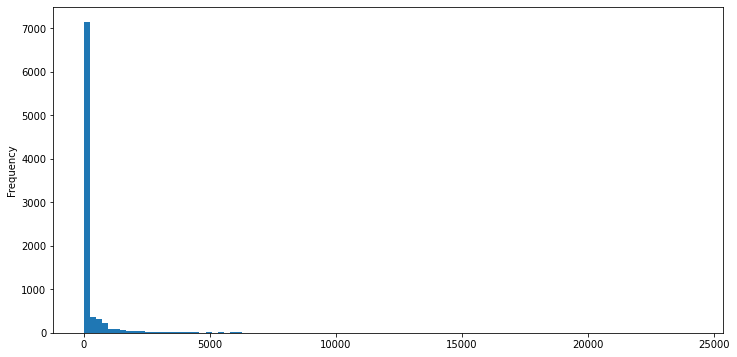

In [128]:
df3['VRDeck'].plot(kind='hist',figsize=(12,6),bins=100)

In [129]:
df3.isna().sum()

HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Transported         0
Cabin_Deck          0
Cabin_Side          0
Total_Bill        908
Total_Bill_Log    908
dtype: int64

In [130]:
df3['Total_Bill'] = df3['RoomService'] + df3['FoodCourt'] + df3['ShoppingMall'] + df3['Spa'] + df3['VRDeck']

In [131]:
df3['Total_Bill_Log'] = np.log(df3['Total_Bill'])

In [132]:
df3.isna().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Cabin_Deck        0
Cabin_Side        0
Total_Bill        0
Total_Bill_Log    0
dtype: int64

In [133]:
df3

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side,Total_Bill,Total_Bill_Log
0,Europa,0,TRAPPIST-1e,39,False,0,0,0,0.0,0,False,B,P,0.0,-inf
1,Earth,0,TRAPPIST-1e,24,False,109,9,25,549.0,44,True,F,S,736.0,6.601230
2,Europa,0,TRAPPIST-1e,58,True,43,3576,0,6715.0,49,False,A,S,10383.0,9.247925
3,Europa,0,TRAPPIST-1e,33,False,0,1283,371,3329.0,193,False,A,S,5176.0,8.551788
4,Earth,0,TRAPPIST-1e,16,False,303,70,151,565.0,2,True,F,S,1091.0,6.994850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,55 Cancri e,41,True,0,6819,0,1643.0,74,False,A,P,8536.0,9.052048
8689,Earth,1,PSO J318.5-22,18,False,0,0,0,0.0,0,False,G,S,0.0,-inf
8690,Earth,0,TRAPPIST-1e,26,False,0,0,1872,1.0,0,True,G,S,1873.0,7.535297
8691,Europa,0,55 Cancri e,32,False,0,1049,0,353.0,3235,False,E,S,4637.0,8.441823


<Axes: >

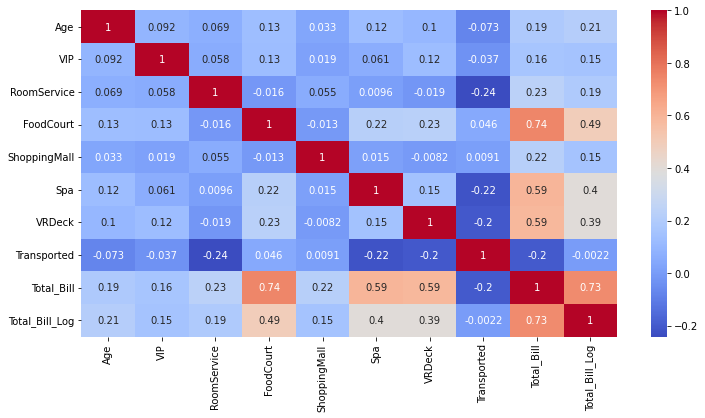

In [134]:
plt.figure(figsize=(12,6))
sns.heatmap(df3.corr(), annot=True, cmap='coolwarm')

<Axes: >

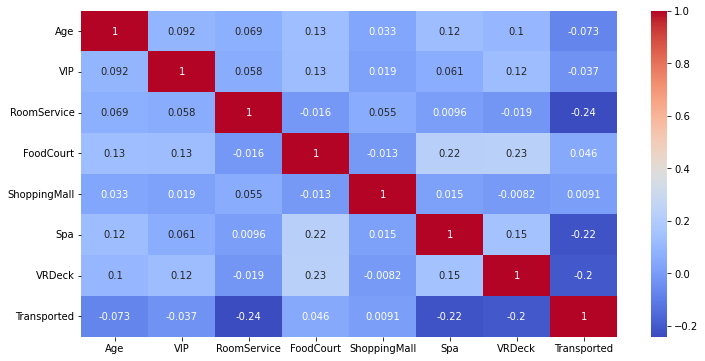

In [135]:
plt.figure(figsize=(12,6))
sns.heatmap(df3.drop(['Total_Bill','Total_Bill_Log'],axis=1).corr(), annot=True, cmap='coolwarm')

In [136]:
df3['Total_Bill'].sum()/1e6

12.5890275

### Total_Bill_Log would give us error while building ML model

# Feature Engineering

In [137]:
df4 = df3.copy()

In [138]:
df4.drop('Total_Bill_Log',axis=1,inplace=True)

In [139]:
df4

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side,Total_Bill
0,Europa,0,TRAPPIST-1e,39,False,0,0,0,0.0,0,False,B,P,0.0
1,Earth,0,TRAPPIST-1e,24,False,109,9,25,549.0,44,True,F,S,736.0
2,Europa,0,TRAPPIST-1e,58,True,43,3576,0,6715.0,49,False,A,S,10383.0
3,Europa,0,TRAPPIST-1e,33,False,0,1283,371,3329.0,193,False,A,S,5176.0
4,Earth,0,TRAPPIST-1e,16,False,303,70,151,565.0,2,True,F,S,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,55 Cancri e,41,True,0,6819,0,1643.0,74,False,A,P,8536.0
8689,Earth,1,PSO J318.5-22,18,False,0,0,0,0.0,0,False,G,S,0.0
8690,Earth,0,TRAPPIST-1e,26,False,0,0,1872,1.0,0,True,G,S,1873.0
8691,Europa,0,55 Cancri e,32,False,0,1049,0,353.0,3235,False,E,S,4637.0


In [140]:
df4['Total_Bill'].describe()

count     8693.000000
mean      1448.179857
std       2807.781884
min          0.000000
25%          0.000000
50%        717.000000
75%       1444.000000
max      35987.000000
Name: Total_Bill, dtype: float64

In [141]:
np.linspace(df4['Total_Bill'].min(),df4['Total_Bill'].max(),6)

array([    0. ,  7197.4, 14394.8, 21592.2, 28789.6, 35987. ])

In [142]:
np.arange(0,7197.4,0.01)

array([0.00000e+00, 1.00000e-02, 2.00000e-02, ..., 7.19737e+03,
       7.19738e+03, 7.19739e+03])

In [143]:
def economy_class(x):
    if (x >= 0) & (x<7197.4):  # in np.arange(0,7197.4,0.01):
        return 1
    elif (x > 7197.4) & (x < 14394.8): #in np.arange(7197.4, 14394.8,0.01):
        return 2
    elif (x > 14394.8) & (x < 21592.2): # in np.arange(14394.8, 21592.2,0.01):
        return 3
    elif (x > 21592.2) & (x < 28789.6): # in np.arange(21592.2, 28789.6,0.01):
        return 4
    elif (x > 28789.6) & (x <= 35987.0): #in np.arange(28789.6, 35987.0,0.01):
        return 5

In [144]:
df4['Economy_Class'] = df4['Total_Bill'].apply(lambda x: economy_class(x))

In [145]:
df4

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side,Total_Bill,Economy_Class
0,Europa,0,TRAPPIST-1e,39,False,0,0,0,0.0,0,False,B,P,0.0,1
1,Earth,0,TRAPPIST-1e,24,False,109,9,25,549.0,44,True,F,S,736.0,1
2,Europa,0,TRAPPIST-1e,58,True,43,3576,0,6715.0,49,False,A,S,10383.0,2
3,Europa,0,TRAPPIST-1e,33,False,0,1283,371,3329.0,193,False,A,S,5176.0,1
4,Earth,0,TRAPPIST-1e,16,False,303,70,151,565.0,2,True,F,S,1091.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,55 Cancri e,41,True,0,6819,0,1643.0,74,False,A,P,8536.0,2
8689,Earth,1,PSO J318.5-22,18,False,0,0,0,0.0,0,False,G,S,0.0,1
8690,Earth,0,TRAPPIST-1e,26,False,0,0,1872,1.0,0,True,G,S,1873.0,1
8691,Europa,0,55 Cancri e,32,False,0,1049,0,353.0,3235,False,E,S,4637.0,1


In [146]:
df4['HomePlanet'].unique()

<StringArray>
['Europa', 'Earth', 'Mars', 'Missing']
Length: 4, dtype: string

In [147]:
df4['Destination'].unique()

<StringArray>
['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', 'Missing']
Length: 4, dtype: string

### Since there are 4 different start points and 4 different end points, we can assume that there are 4*4 = 16 different Paths. Let's make a column

In [148]:
def path_tracer(cols):
    sp = cols[0] # start point
    ep = cols[1] # end point
    if (sp=='Europa') & (ep=='TRAPPIST-1e'):
        return 'Path_1'
    elif (sp=='Europa') & (ep=='PSO J318.5-22'):
        return 'Path_2'
    elif (sp=='Europa') & (ep=='55 Cancri e'):
        return 'Path_3'
    elif (sp=='Europa') & (ep=='Missing'):
        return 'Path_4'
    elif (sp=='Earth') & (ep=='TRAPPIST-1e'):
        return 'Path_5'
    elif (sp=='Earth') & (ep=='PSO J318.5-22'):
        return 'Path_6'
    elif (sp=='Earth') & (ep=='55 Cancri e'):
        return 'Path_7'
    elif (sp=='Earth') & (ep=='Missing'):
        return 'Path_8'
    elif (sp=='Mars') & (ep=='TRAPPIST-1e'):
        return 'Path_9'
    elif (sp=='Mars') & (ep=='PSO J318.5-22'):
        return 'Path_10'
    elif (sp=='Mars') & (ep=='55 Cancri e'):
        return 'Path_11'
    elif (sp=='Mars') & (ep=='Missing'):
        return 'Path_12'
    elif (sp=='Missing') & (ep=='TRAPPIST-1e'):
        return 'Path_13'
    elif (sp=='Missing') & (ep=='PSO J318.5-22'):
        return 'Path_14'
    elif (sp=='Missing') & (ep=='55 Cancri e'):
        return 'Path_15'
    elif (sp=='Missing') & (ep=='Missing'):
        return 'Path_16'

In [149]:
df4['Path'] = df4[['HomePlanet','Destination']].apply(path_tracer,axis=1)

In [150]:
df4

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side,Total_Bill,Economy_Class,Path
0,Europa,0,TRAPPIST-1e,39,False,0,0,0,0.0,0,False,B,P,0.0,1,Path_1
1,Earth,0,TRAPPIST-1e,24,False,109,9,25,549.0,44,True,F,S,736.0,1,Path_5
2,Europa,0,TRAPPIST-1e,58,True,43,3576,0,6715.0,49,False,A,S,10383.0,2,Path_1
3,Europa,0,TRAPPIST-1e,33,False,0,1283,371,3329.0,193,False,A,S,5176.0,1,Path_1
4,Earth,0,TRAPPIST-1e,16,False,303,70,151,565.0,2,True,F,S,1091.0,1,Path_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,55 Cancri e,41,True,0,6819,0,1643.0,74,False,A,P,8536.0,2,Path_3
8689,Earth,1,PSO J318.5-22,18,False,0,0,0,0.0,0,False,G,S,0.0,1,Path_6
8690,Earth,0,TRAPPIST-1e,26,False,0,0,1872,1.0,0,True,G,S,1873.0,1,Path_5
8691,Europa,0,55 Cancri e,32,False,0,1049,0,353.0,3235,False,E,S,4637.0,1,Path_3


In [151]:
df4['Path'].value_counts()

Path_5     3101
Path_9     1475
Path_1     1189
Path_3      886
Path_6      712
Path_7      690
Path_11     193
Path_13     150
Path_8       99
Path_10      49
Path_12      42
Path_4       37
Path_15      31
Path_2       19
Path_14      16
Path_16       4
Name: Path, dtype: int64

## Most passengers travelled from Earth to TRAPPIST-1e

<Axes: xlabel='Path', ylabel='count'>

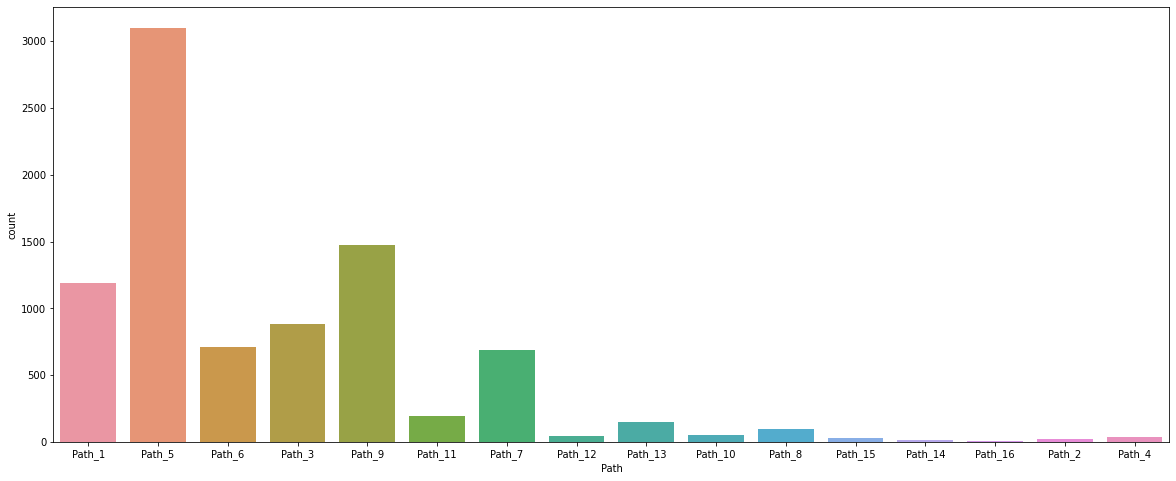

In [152]:
plt.figure(figsize=(20,8))
sns.countplot(data=df4,x='Path')

<Axes: xlabel='Path', ylabel='Total_Bill'>

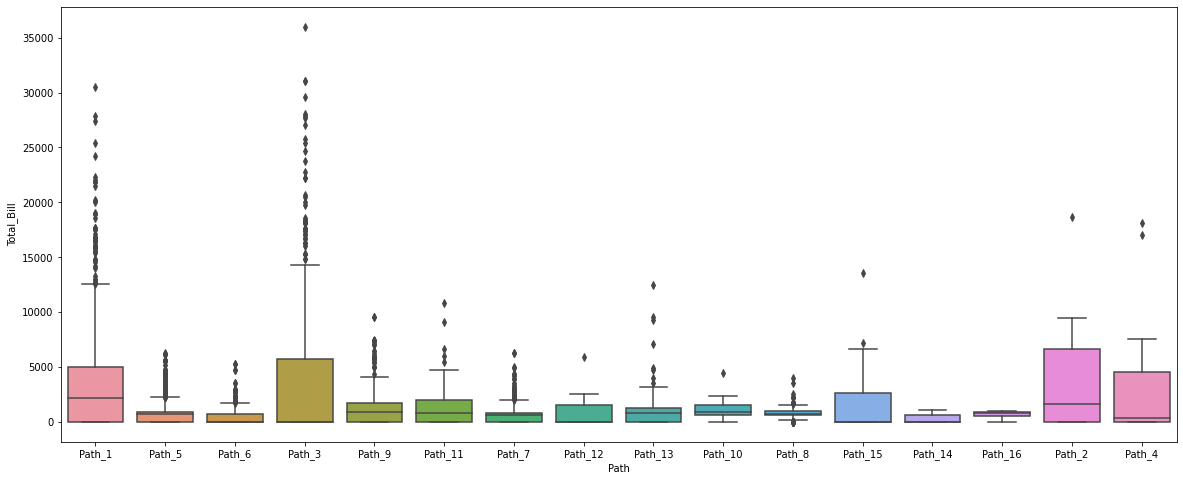

In [153]:
plt.figure(figsize=(20,8))
sns.boxplot(data=df4,x='Path', y='Total_Bill')

<Axes: xlabel='Path', ylabel='Total_Bill'>

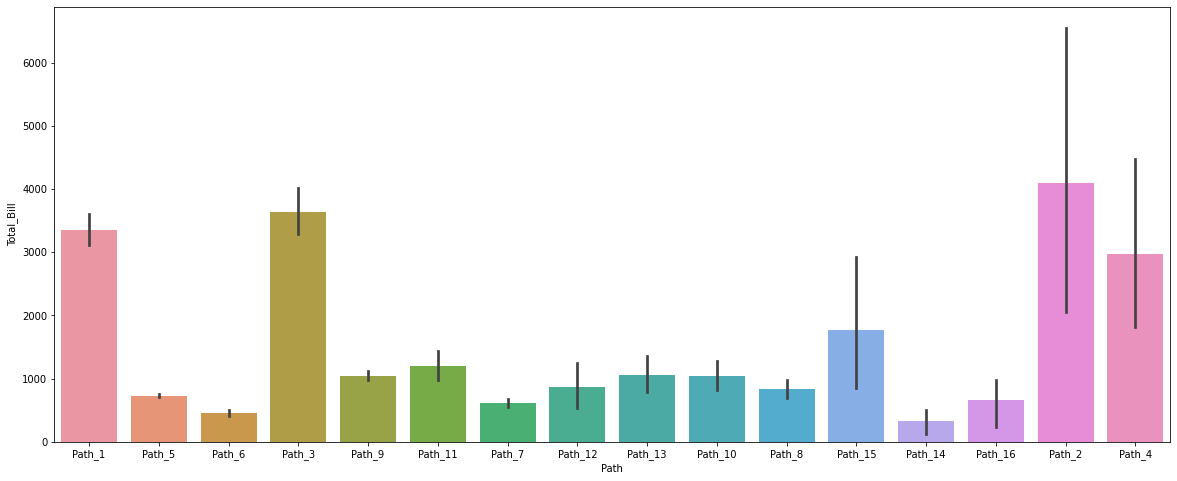

In [154]:
plt.figure(figsize=(20,8))
sns.barplot(data=df4,x='Path', y='Total_Bill')

In [155]:
for i in df4['Path'].unique():
    print(i)
    print(df4[(df4['CryoSleep']==0) & (df4['Path']==i)]['Total_Bill'].median())

Path_1
4290.5
Path_5
827.5
Path_6
721.0
Path_3
5826.0
Path_9
1348.0
Path_11
1719.0
Path_7
720.0
Path_12
1599.0
Path_13
1011.0
Path_10
1295.0
Path_8
804.0
Path_15
3253.5
Path_14
694.5
Path_16
821.0
Path_2
6696.0
Path_4
4423.5


In [156]:
df4[df4['Economy_Class']==5]['Path'].value_counts()

Path_3    4
Path_1    1
Name: Path, dtype: int64

### Although Path 5 (Earth to TRAPPIST-1e) has the highest count but people from Path 2 (Europa to PSO J318.5-22) spent the most. However, the Median Total Bill of Path 3 (Europa to 55 Cancri e) Passengers was highest.

In [157]:
df4[df4['Transported']==True]['CryoSleep'].value_counts()/len(df4[df4['Transported']==True])

1    0.581772
0    0.418228
Name: CryoSleep, dtype: float64

In [158]:
df4[df4['Transported']==False]['CryoSleep'].value_counts()/len(df4[df4['Transported']==False])

0    0.86628
1    0.13372
Name: CryoSleep, dtype: float64

## Also, most of the people who were not Transported were not in CryoSleep.
## Avoiding CryoSleep increases the chances of surviving being Transported.

In [159]:
df4

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Side,Total_Bill,Economy_Class,Path
0,Europa,0,TRAPPIST-1e,39,False,0,0,0,0.0,0,False,B,P,0.0,1,Path_1
1,Earth,0,TRAPPIST-1e,24,False,109,9,25,549.0,44,True,F,S,736.0,1,Path_5
2,Europa,0,TRAPPIST-1e,58,True,43,3576,0,6715.0,49,False,A,S,10383.0,2,Path_1
3,Europa,0,TRAPPIST-1e,33,False,0,1283,371,3329.0,193,False,A,S,5176.0,1,Path_1
4,Earth,0,TRAPPIST-1e,16,False,303,70,151,565.0,2,True,F,S,1091.0,1,Path_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,55 Cancri e,41,True,0,6819,0,1643.0,74,False,A,P,8536.0,2,Path_3
8689,Earth,1,PSO J318.5-22,18,False,0,0,0,0.0,0,False,G,S,0.0,1,Path_6
8690,Earth,0,TRAPPIST-1e,26,False,0,0,1872,1.0,0,True,G,S,1873.0,1,Path_5
8691,Europa,0,55 Cancri e,32,False,0,1049,0,353.0,3235,False,E,S,4637.0,1,Path_3


In [160]:
df5 = df4.copy()

In [161]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   string 
 1   CryoSleep      8693 non-null   object 
 2   Destination    8693 non-null   string 
 3   Age            8693 non-null   int64  
 4   VIP            8693 non-null   boolean
 5   RoomService    8693 non-null   int64  
 6   FoodCourt      8693 non-null   int64  
 7   ShoppingMall   8693 non-null   int64  
 8   Spa            8693 non-null   float64
 9   VRDeck         8693 non-null   int64  
 10  Transported    8693 non-null   boolean
 11  Cabin_Deck     8693 non-null   string 
 12  Cabin_Side     8693 non-null   string 
 13  Total_Bill     8693 non-null   float64
 14  Economy_Class  8693 non-null   int64  
 15  Path           8693 non-null   object 
dtypes: boolean(2), float64(2), int64(6), object(2), string(4)
memory usage: 984.9+ KB


In [162]:
df5['CryoSleep'] = df5['CryoSleep'].astype('int64')

In [163]:
df5['Transported'] = df5['Transported'].astype('bool')

In [164]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   string 
 1   CryoSleep      8693 non-null   int64  
 2   Destination    8693 non-null   string 
 3   Age            8693 non-null   int64  
 4   VIP            8693 non-null   boolean
 5   RoomService    8693 non-null   int64  
 6   FoodCourt      8693 non-null   int64  
 7   ShoppingMall   8693 non-null   int64  
 8   Spa            8693 non-null   float64
 9   VRDeck         8693 non-null   int64  
 10  Transported    8693 non-null   bool   
 11  Cabin_Deck     8693 non-null   string 
 12  Cabin_Side     8693 non-null   string 
 13  Total_Bill     8693 non-null   float64
 14  Economy_Class  8693 non-null   int64  
 15  Path           8693 non-null   object 
dtypes: bool(1), boolean(1), float64(2), int64(7), object(1), string(4)
memory usage: 976.4+ KB


In [165]:
df5.select_dtypes(include=['string','object']).columns

Index(['HomePlanet', 'Destination', 'Cabin_Deck', 'Cabin_Side', 'Path'], dtype='object')

In [166]:
df5 = pd.get_dummies(df5,columns=df5.select_dtypes(include=['string','object']).columns, drop_first=False)

In [167]:
df5

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Total_Bill,...,Path_Path_15,Path_Path_16,Path_Path_2,Path_Path_3,Path_Path_4,Path_Path_5,Path_Path_6,Path_Path_7,Path_Path_8,Path_Path_9
0,0,39,False,0,0,0,0.0,0,False,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,24,False,109,9,25,549.0,44,True,736.0,...,0,0,0,0,0,1,0,0,0,0
2,0,58,True,43,3576,0,6715.0,49,False,10383.0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,False,0,1283,371,3329.0,193,False,5176.0,...,0,0,0,0,0,0,0,0,0,0
4,0,16,False,303,70,151,565.0,2,True,1091.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41,True,0,6819,0,1643.0,74,False,8536.0,...,0,0,0,1,0,0,0,0,0,0
8689,1,18,False,0,0,0,0.0,0,False,0.0,...,0,0,0,0,0,0,1,0,0,0
8690,0,26,False,0,0,1872,1.0,0,True,1873.0,...,0,0,0,0,0,1,0,0,0,0
8691,0,32,False,0,1049,0,353.0,3235,False,4637.0,...,0,0,0,1,0,0,0,0,0,0


In [168]:
X = df5.drop('Transported',axis=1)
y = df5['Transported']

In [169]:
X

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_Bill,Economy_Class,...,Path_Path_15,Path_Path_16,Path_Path_2,Path_Path_3,Path_Path_4,Path_Path_5,Path_Path_6,Path_Path_7,Path_Path_8,Path_Path_9
0,0,39,False,0,0,0,0.0,0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,24,False,109,9,25,549.0,44,736.0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,58,True,43,3576,0,6715.0,49,10383.0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,33,False,0,1283,371,3329.0,193,5176.0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,16,False,303,70,151,565.0,2,1091.0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41,True,0,6819,0,1643.0,74,8536.0,2,...,0,0,0,1,0,0,0,0,0,0
8689,1,18,False,0,0,0,0.0,0,0.0,1,...,0,0,0,0,0,0,1,0,0,0
8690,0,26,False,0,0,1872,1.0,0,1873.0,1,...,0,0,0,0,0,1,0,0,0,0
8691,0,32,False,0,1049,0,353.0,3235,4637.0,1,...,0,0,0,1,0,0,0,0,0,0


CryoSleep


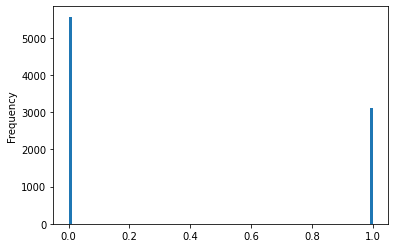

Age


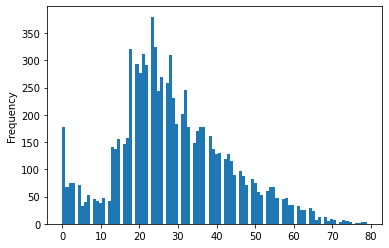

RoomService


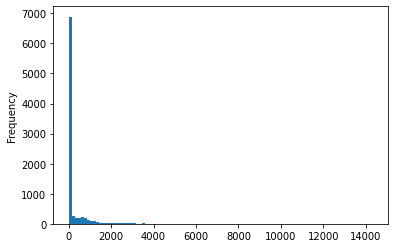

FoodCourt


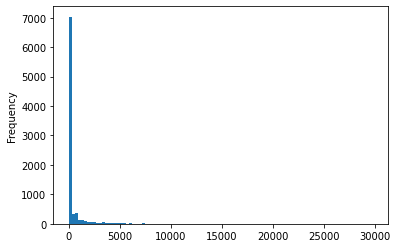

ShoppingMall


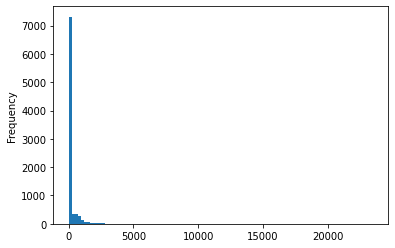

Spa


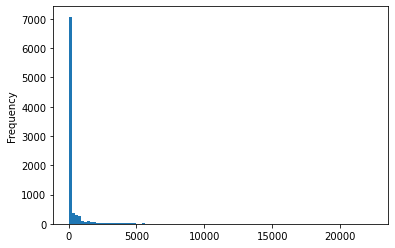

VRDeck


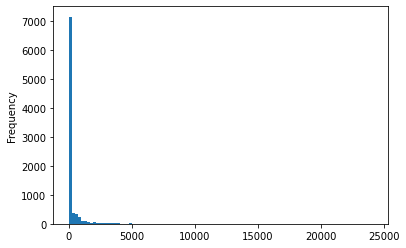

Total_Bill


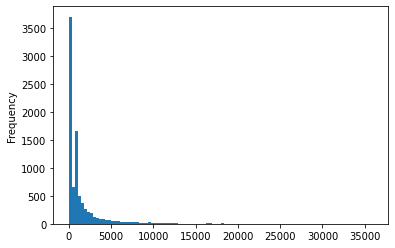

Economy_Class


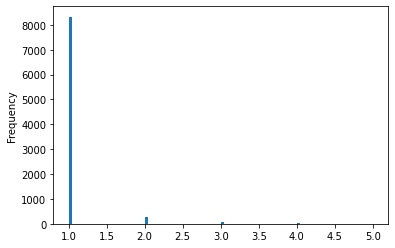

In [170]:
for i in df5.select_dtypes(include=['int64','float64']).columns:
    print(i)
    df5[i].plot(kind='hist',bins=100)
    plt.show();

## Feature Engineering Done. Now, let's start Feature Selection

In [171]:
from sklearn.feature_selection import mutual_info_classif

In [172]:
X.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Total_Bill', 'Economy_Class', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'HomePlanet_Missing',
       'Destination_55 Cancri e', 'Destination_Missing',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Cabin_Deck_A',
       'Cabin_Deck_B', 'Cabin_Deck_C', 'Cabin_Deck_D', 'Cabin_Deck_E',
       'Cabin_Deck_F', 'Cabin_Deck_G', 'Cabin_Deck_Missing', 'Cabin_Deck_T',
       'Cabin_Side_Missing', 'Cabin_Side_P', 'Cabin_Side_S', 'Path_Path_1',
       'Path_Path_10', 'Path_Path_11', 'Path_Path_12', 'Path_Path_13',
       'Path_Path_14', 'Path_Path_15', 'Path_Path_16', 'Path_Path_2',
       'Path_Path_3', 'Path_Path_4', 'Path_Path_5', 'Path_Path_6',
       'Path_Path_7', 'Path_Path_8', 'Path_Path_9'],
      dtype='object')

In [173]:
y

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool

In [174]:
mutual_info = mutual_info_classif(X, y)
mutual_info

array([0.11542732, 0.0163998 , 0.0011233 , 0.07906106, 0.04615925,
       0.04842925, 0.07537505, 0.0640782 , 0.13024548, 0.0007866 ,
       0.01866935, 0.01919786, 0.        , 0.        , 0.00742932,
       0.        , 0.00425555, 0.        , 0.        , 0.00976386,
       0.01034827, 0.        , 0.00635506, 0.00840566, 0.01046784,
       0.        , 0.        , 0.00838562, 0.00116867, 0.00770008,
       0.00403194, 0.        , 0.        , 0.        , 0.01133752,
       0.        , 0.01013539, 0.01216295, 0.        , 0.00119182,
       0.        , 0.01339579, 0.        , 0.        , 0.00313179,
       0.0060006 ])

In [175]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

Total_Bill                   0.130245
CryoSleep                    0.115427
RoomService                  0.079061
Spa                          0.075375
VRDeck                       0.064078
ShoppingMall                 0.048429
FoodCourt                    0.046159
HomePlanet_Europa            0.019198
HomePlanet_Earth             0.018669
Age                          0.016400
Path_Path_5                  0.013396
Path_Path_16                 0.012163
Path_Path_13                 0.011338
Cabin_Deck_G                 0.010468
Cabin_Deck_C                 0.010348
Path_Path_15                 0.010135
Cabin_Deck_B                 0.009764
Cabin_Deck_F                 0.008406
Cabin_Side_Missing           0.008386
Cabin_Side_S                 0.007700
Destination_55 Cancri e      0.007429
Cabin_Deck_E                 0.006355
Path_Path_9                  0.006001
Destination_PSO J318.5-22    0.004256
Path_Path_1                  0.004032
Path_Path_8                  0.003132
Path_Path_3 

## Top 20 most imp features

<Axes: >

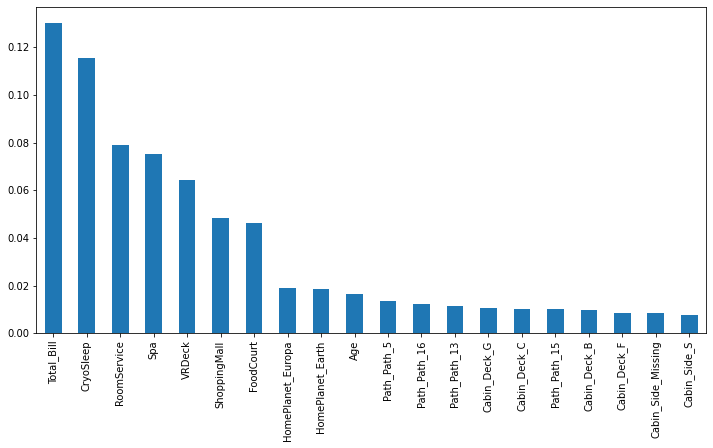

In [176]:
mutual_info.sort_values(ascending=False).head(20).plot(kind='bar',figsize=(12,6))

## Splitting and Scaling

In [177]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [179]:
sc = StandardScaler()
mm = MinMaxScaler()

In [180]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [181]:
X_train_mm = mm.fit_transform(X_train)
X_test_mm = mm.transform(X_test)

In [182]:
X_train_sc

array([[-0.73701442,  0.4335046 , -0.15404546, ..., -0.29387835,
        -0.10540926,  2.23560736],
       [-0.73701442, -0.05421798, -0.15404546, ..., -0.29387835,
        -0.10540926, -0.44730574],
       [ 1.35682556,  0.99090184, -0.15404546, ..., -0.29387835,
        -0.10540926,  2.23560736],
       ...,
       [-0.73701442, -0.47226591, -0.15404546, ..., -0.29387835,
        -0.10540926, -0.44730574],
       [-0.73701442,  0.36382995, -0.15404546, ..., -0.29387835,
        -0.10540926,  2.23560736],
       [-0.73701442, -0.05421798, -0.15404546, ..., -0.29387835,
        -0.10540926, -0.44730574]])

## Now let's use some AutoML libraries to know which algo would be good

In [183]:
#df5.to_csv('train_cleaned.csv',index=False)

## 1) FlamL

In [184]:
from flaml import AutoML

In [185]:
automl = AutoML()

In [186]:
automl_settings = {
    'time_budget':30, # in seconds
    'metric': 'accuracy',
    'task':'classification'
}

In [187]:
automl.fit(X_train,y_train, **automl_settings)

[flaml.automl.automl: 03-17 19:04:49] {2726} INFO - task = classification
[flaml.automl.automl: 03-17 19:04:49] {2728} INFO - Data split method: stratified
[flaml.automl.automl: 03-17 19:04:49] {2731} INFO - Evaluation method: holdout
[flaml.automl.automl: 03-17 19:04:49] {2858} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.automl: 03-17 19:04:49] {3004} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.automl: 03-17 19:04:49] {3334} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-17 19:04:49] {3472} INFO - Estimated sufficient time budget=472s. Estimated necessary time budget=12s.
[flaml.automl.automl: 03-17 19:04:49] {3519} INFO -  at 0.2s,	estimator lgbm's best error=0.2650,	best estimator lgbm's best error=0.2650
[flaml.automl.automl: 03-17 19:04:49] {3334} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-17 19:04:49] {3519} INFO -  at 0.3s,	estimator lg

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.automl: 03-17 19:05:20] {3519} INFO -  at 30.5s,	estimator lrl1's best error=0.2222,	best estimator xgboost's best error=0.2000
[flaml.automl.automl: 03-17 19:05:20] {3783} INFO - retrain xgboost for 0.2s
[flaml.automl.automl: 03-17 19:05:20] {3790} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.9528676738644739, colsample_bynode=None,
              colsample_bytree=0.6980216487058154, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.6413547778096401, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=16,
              min_child_weight=12.49957082554637, missing=nan,
              monotone_constraints=None, 

In [188]:
print(automl.model)

In [189]:
y_pred = automl.predict(X_test)

In [190]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [191]:
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.79      0.77      0.78      1424
        True       0.78      0.80      0.79      1445

    accuracy                           0.79      2869
   macro avg       0.79      0.79      0.79      2869
weighted avg       0.79      0.79      0.79      2869

[[1095  329]
 [ 283 1162]]
0.7866852561868247
0.7915531335149864


In [192]:
automl.best_result

{'pred_time': 8.959647936698718e-06,
 'wall_clock_time': 2.0261075496673584,
 'metric_for_logging': {'pred_time': 8.959647936698718e-06},
 'val_loss': 0.19999999999999996,
 'training_iteration': 1,
 'config': {'n_estimators': 26,
  'max_leaves': 16,
  'min_child_weight': 12.49957082554637,
  'learning_rate': 0.6413547778096401,
  'subsample': 1.0,
  'colsample_bylevel': 0.9528676738644739,
  'colsample_bytree': 0.6980216487058154,
  'reg_alpha': 0.015338994407265423,
  'reg_lambda': 0.6187883856240529},
 'config/n_estimators': 26,
 'config/max_leaves': 16,
 'config/min_child_weight': 12.49957082554637,
 'config/learning_rate': 0.6413547778096401,
 'config/subsample': 1.0,
 'config/colsample_bylevel': 0.9528676738644739,
 'config/colsample_bytree': 0.6980216487058154,
 'config/reg_alpha': 0.015338994407265423,
 'config/reg_lambda': 0.6187883856240529,
 'experiment_tag': 'exp',
 'time_total_s': 0.09947586059570312}

In [193]:
automl.best_estimator

'xgboost'

In [194]:
import pickle

### Now Let's preprocess the test file as well

In [195]:
X_train

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_Bill,Economy_Class,...,Path_Path_15,Path_Path_16,Path_Path_2,Path_Path_3,Path_Path_4,Path_Path_5,Path_Path_6,Path_Path_7,Path_Path_8,Path_Path_9
4696,0,35,False,1337,49,57,0.0,0,1443.0,1,...,0,0,0,0,0,0,0,0,0,1
5946,0,28,False,0,152,215,30.0,510,907.0,1,...,0,0,0,0,0,1,0,0,0,0
227,1,43,False,0,0,0,0.0,0,0.0,1,...,0,0,0,0,0,0,0,0,0,1
3950,1,65,False,0,0,0,0.0,0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
7674,0,18,False,0,0,19,751.0,4,774.0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0,18,False,14,2,144,610.0,0,770.0,1,...,0,0,0,0,0,1,0,0,0,0
5191,0,50,False,690,0,30,762.0,428,1910.0,1,...,0,0,0,0,0,0,0,0,0,1
5390,0,22,False,158,0,476,0.0,26,660.0,1,...,0,0,0,0,0,0,1,0,0,0
860,0,34,False,379,0,1626,0.0,0,2005.0,1,...,0,0,0,0,0,0,0,0,0,1


In [196]:
automl.best_estimator

'xgboost'

In [197]:
mutual_info[mutual_info.sort_values(ascending=False) > 0].index

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Total_Bill', 'Economy_Class', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Cabin_Deck_B', 'Cabin_Deck_C',
       'Cabin_Deck_E', 'Cabin_Deck_F', 'Cabin_Deck_G', 'Cabin_Side_Missing',
       'Cabin_Side_P', 'Cabin_Side_S', 'Path_Path_1', 'Path_Path_13',
       'Path_Path_15', 'Path_Path_16', 'Path_Path_3', 'Path_Path_5',
       'Path_Path_8', 'Path_Path_9'],
      dtype='object')

In [198]:
X_mig_train = X_train[mutual_info[mutual_info.sort_values(ascending=False) > 0].index].copy()

In [199]:
X_mig_test = X_test[mutual_info[mutual_info.sort_values(ascending=False) > 0].index].copy()

In [200]:
automl_mig = AutoML()

In [201]:
automl_settings_mig = {
    'time_budget':30, # in seconds
    'metric': 'accuracy',
    'task':'classification'
}

In [202]:
automl_mig.fit(X_mig_train,y_train, **automl_settings)

[flaml.automl.automl: 03-17 19:05:20] {2726} INFO - task = classification
[flaml.automl.automl: 03-17 19:05:20] {2728} INFO - Data split method: stratified
[flaml.automl.automl: 03-17 19:05:20] {2731} INFO - Evaluation method: holdout
[flaml.automl.automl: 03-17 19:05:20] {2858} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.automl: 03-17 19:05:20] {3004} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.automl: 03-17 19:05:20] {3334} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 03-17 19:05:20] {3472} INFO - Estimated sufficient time budget=299s. Estimated necessary time budget=7s.
[flaml.automl.automl: 03-17 19:05:20] {3519} INFO -  at 0.1s,	estimator lgbm's best error=0.2650,	best estimator lgbm's best error=0.2650
[flaml.automl.automl: 03-17 19:05:20] {3334} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 03-17 19:05:20] {3519} INFO -  at 0.2s,	estimator lgb

In [203]:
y_pred_mig = automl_mig.predict(X_mig_test)

In [204]:
print(classification_report(y_test,y_pred_mig))
print(confusion_matrix(y_test,y_pred_mig))
print(accuracy_score(y_test,y_pred_mig))
print(f1_score(y_test,y_pred_mig))

              precision    recall  f1-score   support

       False       0.82      0.75      0.78      1424
        True       0.77      0.84      0.80      1445

    accuracy                           0.79      2869
   macro avg       0.80      0.79      0.79      2869
weighted avg       0.80      0.79      0.79      2869

[[1065  359]
 [ 233 1212]]
0.7936563262460787
0.8037135278514588


In [205]:
automl_mig.best_estimator

'lgbm'

In [206]:
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.79      0.77      0.78      1424
        True       0.78      0.80      0.79      1445

    accuracy                           0.79      2869
   macro avg       0.79      0.79      0.79      2869
weighted avg       0.79      0.79      0.79      2869

[[1095  329]
 [ 283 1162]]
0.7866852561868247
0.7915531335149864


In [207]:
automl.best_estimator

'xgboost'

In [208]:
automl.best_config

{'n_estimators': 26,
 'max_leaves': 16,
 'min_child_weight': 12.49957082554637,
 'learning_rate': 0.6413547778096401,
 'subsample': 1.0,
 'colsample_bylevel': 0.9528676738644739,
 'colsample_bytree': 0.6980216487058154,
 'reg_alpha': 0.015338994407265423,
 'reg_lambda': 0.6187883856240529}

## Let's use catboost with optuna

In [209]:
X_train['VIP'] = X_train['VIP'].astype('bool')

In [210]:
X_test['VIP'] = X_test['VIP'].astype('bool')

In [211]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [212]:
import catboost

In [213]:
import optuna
from optuna.samplers import TPESampler

In [214]:
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred_trial = model.predict(X_test)
    y_pred_true = np.where(y_pred_trial=='True',True,False)
    return accuracy_score(y_test, y_pred_true)

In [215]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

In [216]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.8058556988497735
  Params: 
    iterations: 939
    learning_rate: 0.02858170206560953
    depth: 6
    l2_leaf_reg: 0.005999417891617477
    bootstrap_type: Bayesian
    random_strength: 3.911857458263341e-07
    bagging_temperature: 1.096239042801322
    od_type: IncToDec
    od_wait: 33


In [217]:
trial.params

{'iterations': 939,
 'learning_rate': 0.02858170206560953,
 'depth': 6,
 'l2_leaf_reg': 0.005999417891617477,
 'bootstrap_type': 'Bayesian',
 'random_strength': 3.911857458263341e-07,
 'bagging_temperature': 1.096239042801322,
 'od_type': 'IncToDec',
 'od_wait': 33}

In [218]:
automl.best_config_per_estimator

{'lgbm': {'n_estimators': 11,
  'num_leaves': 39,
  'min_child_samples': 24,
  'learning_rate': 0.16654005213567946,
  'log_max_bin': 10,
  'colsample_bytree': 0.4412205154946838,
  'reg_alpha': 0.0009765625,
  'reg_lambda': 0.053913177376520016},
 'rf': {'n_estimators': 17,
  'max_features': 0.2344389250952406,
  'max_leaves': 88,
  'criterion': 'gini'},
 'catboost': {'early_stopping_rounds': 15,
  'learning_rate': 0.041482194224457695,
  'n_estimators': 208},
 'xgboost': {'n_estimators': 26,
  'max_leaves': 16,
  'min_child_weight': 12.49957082554637,
  'learning_rate': 0.6413547778096401,
  'subsample': 1.0,
  'colsample_bylevel': 0.9528676738644739,
  'colsample_bytree': 0.6980216487058154,
  'reg_alpha': 0.015338994407265423,
  'reg_lambda': 0.6187883856240529},
 'extra_tree': {'n_estimators': 14,
  'max_features': 0.26757711031553305,
  'max_leaves': 181,
  'criterion': 'gini'},
 'xgb_limitdepth': {'n_estimators': 10,
  'max_depth': 5,
  'min_child_weight': 2.6471373397827658,
  

In [219]:
automl.best_result

{'pred_time': 8.959647936698718e-06,
 'wall_clock_time': 2.0261075496673584,
 'metric_for_logging': {'pred_time': 8.959647936698718e-06},
 'val_loss': 0.19999999999999996,
 'training_iteration': 1,
 'config': {'n_estimators': 26,
  'max_leaves': 16,
  'min_child_weight': 12.49957082554637,
  'learning_rate': 0.6413547778096401,
  'subsample': 1.0,
  'colsample_bylevel': 0.9528676738644739,
  'colsample_bytree': 0.6980216487058154,
  'reg_alpha': 0.015338994407265423,
  'reg_lambda': 0.6187883856240529},
 'config/n_estimators': 26,
 'config/max_leaves': 16,
 'config/min_child_weight': 12.49957082554637,
 'config/learning_rate': 0.6413547778096401,
 'config/subsample': 1.0,
 'config/colsample_bylevel': 0.9528676738644739,
 'config/colsample_bytree': 0.6980216487058154,
 'config/reg_alpha': 0.015338994407265423,
 'config/reg_lambda': 0.6187883856240529,
 'experiment_tag': 'exp',
 'time_total_s': 0.09947586059570312}

In [220]:
import catboost

In [221]:
from catboost import CatBoostClassifier

## 1) Catboost

In [222]:
from catboost import CatBoostClassifier

#### First let's try the automl config

In [223]:
cb = CatBoostClassifier(n_estimators=9000, early_stopping_rounds=15, learning_rate=0.02858170206560953)

In [224]:
cb.fit(X_train,y_train,eval_set=(X_test,y_test),use_best_model=True, verbose=1000)

0:	learn: 0.6807121	test: 0.6810717	best: 0.6810717 (0)	total: 9.65ms	remaining: 1m 26s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 0.4073951247
bestIteration = 477

Shrink model to first 478 iterations.


In [225]:
y_pred_cb_1 = cb.predict(X_test)

In [226]:
y_pred_cb_1 = np.where(y_pred_cb_1=='True',True,False)

In [227]:
print(classification_report(y_test,y_pred_cb_1))
print(confusion_matrix(y_test,y_pred_cb_1))
print(accuracy_score(y_test,y_pred_cb_1))
print(f1_score(y_test,y_pred_cb_1))

              precision    recall  f1-score   support

       False       0.83      0.75      0.79      1424
        True       0.78      0.85      0.81      1445

    accuracy                           0.80      2869
   macro avg       0.80      0.80      0.80      2869
weighted avg       0.80      0.80      0.80      2869

[[1072  352]
 [ 219 1226]]
0.8009759498082956
0.8111147866357922


In [228]:
from sklearn.model_selection import cross_validate, StratifiedKFold

In [229]:
#cb_cv

In [230]:
#cb_cv = cross_validate(cb, X_train, y_train, scoring=['accuracy'], cv=StratifiedKFold(n_splits=10,shuffle=True, random_state=42))

#### Let's try Optuna's configuration

In [231]:
trial.params

{'iterations': 939,
 'learning_rate': 0.02858170206560953,
 'depth': 6,
 'l2_leaf_reg': 0.005999417891617477,
 'bootstrap_type': 'Bayesian',
 'random_strength': 3.911857458263341e-07,
 'bagging_temperature': 1.096239042801322,
 'od_type': 'IncToDec',
 'od_wait': 33}

In [232]:
cb_2 = CatBoostClassifier(**trial.params)
cb_2.fit(X_train,y_train,eval_set=(X_test,y_test),use_best_model=True, verbose=100)
y_pred_cb_2 = cb_2.predict(X_test)
y_pred_cb_2 = np.where(y_pred_cb_2=='True',True,False)
print(classification_report(y_test,y_pred_cb_2))
print(confusion_matrix(y_test,y_pred_cb_2))
print(accuracy_score(y_test,y_pred_cb_2))
print(f1_score(y_test,y_pred_cb_2))

0:	learn: 0.6782093	test: 0.6787008	best: 0.6787008 (0)	total: 4.13ms	remaining: 3.88s
100:	learn: 0.3879468	test: 0.4302150	best: 0.4302150 (100)	total: 898ms	remaining: 7.45s
200:	learn: 0.3491918	test: 0.4158409	best: 0.4157921 (199)	total: 1.66s	remaining: 6.09s
300:	learn: 0.3236737	test: 0.4102745	best: 0.4102151 (299)	total: 3.04s	remaining: 6.45s
400:	learn: 0.3024840	test: 0.4104649	best: 0.4100417 (302)	total: 4.95s	remaining: 6.64s
500:	learn: 0.2851145	test: 0.4117367	best: 0.4100417 (302)	total: 6.15s	remaining: 5.37s
600:	learn: 0.2709272	test: 0.4123579	best: 0.4100417 (302)	total: 7.15s	remaining: 4.02s
700:	learn: 0.2585997	test: 0.4121558	best: 0.4100417 (302)	total: 7.98s	remaining: 2.71s
800:	learn: 0.2478361	test: 0.4134142	best: 0.4100417 (302)	total: 8.79s	remaining: 1.51s
900:	learn: 0.2377384	test: 0.4148311	best: 0.4100417 (302)	total: 9.65s	remaining: 407ms
938:	learn: 0.2343803	test: 0.4158562	best: 0.4100417 (302)	total: 10.1s	remaining: 0us

bestTest = 0.4

In [233]:
cb_3 = CatBoostClassifier(**trial.params, feature_border_type='MaxLogSum', leaf_estimation_method='Newton')  # Maxlogsum = 80.13 ; 
cb_3.fit(X_train,y_train,eval_set=(X_test,y_test),use_best_model=True, verbose=100)
y_pred_cb_3 = cb_3.predict(X_test)
y_pred_cb_3 = np.where(y_pred_cb_3=='True',True,False)
print(classification_report(y_test,y_pred_cb_3))
print(confusion_matrix(y_test,y_pred_cb_3))
print(accuracy_score(y_test,y_pred_cb_3))
print(f1_score(y_test,y_pred_cb_3))

0:	learn: 0.6788042	test: 0.6793545	best: 0.6793545 (0)	total: 22.4ms	remaining: 21.1s
100:	learn: 0.3899467	test: 0.4311497	best: 0.4311497 (100)	total: 1.26s	remaining: 10.5s
200:	learn: 0.3492215	test: 0.4145585	best: 0.4145566 (197)	total: 2.26s	remaining: 8.31s
300:	learn: 0.3239852	test: 0.4106671	best: 0.4106671 (300)	total: 3.39s	remaining: 7.18s
400:	learn: 0.3027771	test: 0.4088875	best: 0.4087495 (396)	total: 4.36s	remaining: 5.85s
500:	learn: 0.2855727	test: 0.4082753	best: 0.4072764 (440)	total: 6.04s	remaining: 5.28s
600:	learn: 0.2709125	test: 0.4097256	best: 0.4072764 (440)	total: 7.74s	remaining: 4.35s
700:	learn: 0.2570705	test: 0.4122122	best: 0.4072764 (440)	total: 9.15s	remaining: 3.11s
800:	learn: 0.2457070	test: 0.4147070	best: 0.4072764 (440)	total: 10.2s	remaining: 1.76s
900:	learn: 0.2354840	test: 0.4174859	best: 0.4072764 (440)	total: 11.5s	remaining: 486ms
938:	learn: 0.2322482	test: 0.4183025	best: 0.4072764 (440)	total: 11.9s	remaining: 0us

bestTest = 0.4

## Gave a Kaggle score of 80.83% accuracy

In [234]:
cb_3_mig = CatBoostClassifier(**trial.params, feature_border_type='MaxLogSum', leaf_estimation_method='Newton')  # Maxlogsum = 80.13 ; 
cb_3_mig.fit(X_mig_train,y_train,eval_set=(X_mig_test,y_test),use_best_model=True, verbose=100)
y_pred_cb_3_mig = cb_3_mig.predict(X_mig_test)
y_pred_cb_3_mig = np.where(y_pred_cb_3_mig=='True',True,False)
print(classification_report(y_test,y_pred_cb_3_mig))
print(confusion_matrix(y_test,y_pred_cb_3_mig))
print(accuracy_score(y_test,y_pred_cb_3_mig))
print(f1_score(y_test,y_pred_cb_3_mig))

0:	learn: 0.6788042	test: 0.6793545	best: 0.6793545 (0)	total: 15.1ms	remaining: 14.1s
100:	learn: 0.3899629	test: 0.4303959	best: 0.4303959 (100)	total: 1.25s	remaining: 10.4s
200:	learn: 0.3495847	test: 0.4162149	best: 0.4160901 (199)	total: 2.92s	remaining: 10.7s
300:	learn: 0.3249033	test: 0.4134965	best: 0.4132374 (295)	total: 4.06s	remaining: 8.62s
400:	learn: 0.3036123	test: 0.4132149	best: 0.4126755 (378)	total: 5.36s	remaining: 7.18s
500:	learn: 0.2872426	test: 0.4123934	best: 0.4120897 (463)	total: 6.99s	remaining: 6.11s
600:	learn: 0.2727913	test: 0.4128756	best: 0.4115951 (535)	total: 8.96s	remaining: 5.04s
700:	learn: 0.2599591	test: 0.4142706	best: 0.4115951 (535)	total: 10s	remaining: 3.4s
800:	learn: 0.2491041	test: 0.4159857	best: 0.4115951 (535)	total: 11s	remaining: 1.89s
900:	learn: 0.2382340	test: 0.4181495	best: 0.4115951 (535)	total: 11.8s	remaining: 498ms
938:	learn: 0.2346502	test: 0.4191336	best: 0.4115951 (535)	total: 12s	remaining: 0us

bestTest = 0.41159510

### Let's try out cb_1 on cleaned test data

In [235]:
df_test = pd.read_csv('test-cleaned.csv')

In [236]:
df_test['VIP'] = df_test['VIP'].astype('bool')

In [237]:
X['VIP'] = X['VIP'].astype('bool')

In [238]:
X

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_Bill,Economy_Class,...,Path_Path_15,Path_Path_16,Path_Path_2,Path_Path_3,Path_Path_4,Path_Path_5,Path_Path_6,Path_Path_7,Path_Path_8,Path_Path_9
0,0,39,False,0,0,0,0.0,0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,24,False,109,9,25,549.0,44,736.0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,58,True,43,3576,0,6715.0,49,10383.0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,33,False,0,1283,371,3329.0,193,5176.0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,16,False,303,70,151,565.0,2,1091.0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41,True,0,6819,0,1643.0,74,8536.0,2,...,0,0,0,1,0,0,0,0,0,0
8689,1,18,False,0,0,0,0.0,0,0.0,1,...,0,0,0,0,0,0,1,0,0,0
8690,0,26,False,0,0,1872,1.0,0,1873.0,1,...,0,0,0,0,0,1,0,0,0,0
8691,0,32,False,0,1049,0,353.0,3235,4637.0,1,...,0,0,0,1,0,0,0,0,0,0


In [239]:
cb_full = CatBoostClassifier(**trial.params, feature_border_type='MaxLogSum', leaf_estimation_method='Newton')

In [240]:
cb_full.fit(X,y,use_best_model=True, verbose=100)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.6775537	total: 15.7ms	remaining: 14.7s
100:	learn: 0.4013544	total: 970ms	remaining: 8.05s
200:	learn: 0.3678932	total: 1.85s	remaining: 6.8s
300:	learn: 0.3468557	total: 3.23s	remaining: 6.85s
400:	learn: 0.3301232	total: 4.53s	remaining: 6.07s
500:	learn: 0.3157581	total: 5.43s	remaining: 4.75s
600:	learn: 0.3033576	total: 6.83s	remaining: 3.84s
700:	learn: 0.2921438	total: 8.69s	remaining: 2.95s
800:	learn: 0.2817047	total: 9.57s	remaining: 1.65s
900:	learn: 0.2725859	total: 10s	remaining: 423ms
938:	learn: 0.2690686	total: 10.2s	remaining: 0us


In [241]:
cb_pred_test = cb_full.predict(df_test)

In [242]:
cb_pred_test = np.where(cb_pred_test=='True',True,False)

In [243]:
test = pd.read_csv('test.csv')

In [244]:
df_test_for_submission = test[['PassengerId']].copy()

In [245]:
df_test_for_submission['Transported'] = cb_pred_test

In [246]:
df_test_for_submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [247]:
#df_test_for_submission.to_csv('cb_automl_config_advanced.csv',index=False)

## The above gave an accuracy of 0.8083 on Kaggle

### Let's try XGB

In [248]:
from xgboost import XGBClassifier

In [249]:
automl.best_config_per_estimator['xgboost']

{'n_estimators': 26,
 'max_leaves': 16,
 'min_child_weight': 12.49957082554637,
 'learning_rate': 0.6413547778096401,
 'subsample': 1.0,
 'colsample_bylevel': 0.9528676738644739,
 'colsample_bytree': 0.6980216487058154,
 'reg_alpha': 0.015338994407265423,
 'reg_lambda': 0.6187883856240529}

In [250]:
params_XGB_best= {'lambda': 3.0610042624477543, 
             'alpha': 4.581902571574289, 
             'colsample_bytree': 0.9241969052729379, 
             'subsample': 0.9527591724824661, 
             'learning_rate': 0.06672065863100594, 
             'n_estimators': 730, #initial value is 651
             'max_depth': 5, 
             'min_child_weight': 1, 
             'num_parallel_tree': 1,'eval_metric':'mlogloss'}

In [251]:
xgb_1 = XGBClassifier(random_state=42, **params_XGB_best)

In [252]:
xgb_1.fit(X_train,y_train)

XGBClassifier(alpha=4.581902571574289, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9241969052729379, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=3.0610042624477543, learning_rate=0.06672065863100594,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=730, n_jobs=None, num_parallel_tree=1, ...)

In [253]:
xgb_1_pred = xgb_1.predict(X_test)

In [254]:
xgb_1_pred = np.where(xgb_1_pred==1,True,False)

In [255]:
xgb_1_pred

array([False,  True,  True, ..., False, False,  True])

In [256]:
print(classification_report(y_test,xgb_1_pred))
print(confusion_matrix(y_test,xgb_1_pred))
print(accuracy_score(y_test,xgb_1_pred))
print(f1_score(y_test,xgb_1_pred))

              precision    recall  f1-score   support

       False       0.81      0.77      0.79      1424
        True       0.78      0.82      0.80      1445

    accuracy                           0.79      2869
   macro avg       0.79      0.79      0.79      2869
weighted avg       0.79      0.79      0.79      2869

[[1094  330]
 [ 264 1181]]
0.7929592192401533
0.7990527740189445


In [257]:
xgb_2 = XGBClassifier(random_state=42, **automl.best_config_per_estimator['xgboost'])
xgb_2.fit(X_train,y_train)
xgb_2_pred = xgb_2.predict(X_test)
xgb_2_pred = np.where(xgb_2_pred==1,True,False)
print(classification_report(y_test,xgb_2_pred))
print(confusion_matrix(y_test,xgb_2_pred))
print(accuracy_score(y_test,xgb_2_pred))
print(f1_score(y_test,xgb_2_pred))

              precision    recall  f1-score   support

       False       0.80      0.77      0.79      1424
        True       0.78      0.81      0.80      1445

    accuracy                           0.79      2869
   macro avg       0.79      0.79      0.79      2869
weighted avg       0.79      0.79      0.79      2869

[[1097  327]
 [ 270 1175]]
0.7919135587312652
0.7974211062097047


In [258]:
def objective_xgb(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [259]:
study_xgb = optuna.create_study(direction='maximize')

In [260]:
study_xgb.optimize(objective_xgb, n_trials=100)

In [261]:
print('Number of finished trials: {}'.format(len(study_xgb.trials)))
print('Best trial:')
trial_xgb = study_xgb.best_trial

print('  Value: {}'.format(trial_xgb.value))
print('  Params: ')

for key, value in trial_xgb.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7978389682816313
  Params: 
    max_depth: 5
    learning_rate: 0.021822543351029573
    n_estimators: 471
    min_child_weight: 6
    gamma: 0.13627268893403185
    subsample: 0.6099602104333527
    colsample_bytree: 0.5117667887183114
    reg_alpha: 0.001629274822727789
    reg_lambda: 3.1749272020926196e-07


In [262]:
xgb_3 = XGBClassifier(max_depth=6,learning_rate= 0.02039550807214109,n_estimators= 467, gamma= 3.103086619210041e-06, subsample= 0.7763351834021972,  colsample_bytree= 0.7931603471114623, reg_alpha= 2.943472564301414e-07,
                      reg_lambda= 1.4042540378743637e-07,random_state=42, booster = 'dart', max_leaves =4)
xgb_3.fit(X_train,y_train)
xgb_3_pred = xgb_3.predict(X_test)
xgb_3_pred = np.where(xgb_3_pred==1,True,False)
print(classification_report(y_test,xgb_3_pred))
print(confusion_matrix(y_test,xgb_3_pred))
print(accuracy_score(y_test,xgb_3_pred))
print(f1_score(y_test,xgb_3_pred))

              precision    recall  f1-score   support

       False       0.82      0.77      0.79      1424
        True       0.78      0.83      0.81      1445

    accuracy                           0.80      2869
   macro avg       0.80      0.80      0.80      2869
weighted avg       0.80      0.80      0.80      2869

[[1091  333]
 [ 247 1198]]
0.7978389682816313
0.8051075268817206


In [263]:
xgb_full = XGBClassifier(max_depth=6,learning_rate= 0.02039550807214109,n_estimators= 467, gamma= 3.103086619210041e-06, subsample= 0.7763351834021972,  colsample_bytree= 0.7931603471114623, reg_alpha= 2.943472564301414e-07,
                      reg_lambda= 1.4042540378743637e-07,random_state=42, booster = 'dart', max_leaves =4)

In [264]:
xgb_full.fit(X,y)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7931603471114623, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.103086619210041e-06, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02039550807214109, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=4,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=467, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [265]:
xgb_pred_test = xgb_full.predict(df_test)

In [266]:
xgb_pred_test = np.where(xgb_pred_test==1,True,False)

In [267]:
df_test_for_submission['Transported'] = xgb_pred_test

In [268]:
#df_test_for_submission.to_csv('xgb_1.csv',index=False)

## XGB Outperformed Catboost on Kaggle. New accuracy: 80.921%

## 3) Tensorflow decision forest

In [270]:
!pip install tensorflow-decision-forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 28.8 MB/s eta 0:00:00


In [271]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

In [277]:
pd.concat([X_train,y_train],axis=1)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_Bill,Economy_Class,...,Path_Path_16,Path_Path_2,Path_Path_3,Path_Path_4,Path_Path_5,Path_Path_6,Path_Path_7,Path_Path_8,Path_Path_9,Transported
4696,0,35,False,1337,49,57,0.0,0,1443.0,1,...,0,0,0,0,0,0,0,0,1,False
5946,0,28,False,0,152,215,30.0,510,907.0,1,...,0,0,0,0,1,0,0,0,0,False
227,1,43,False,0,0,0,0.0,0,0.0,1,...,0,0,0,0,0,0,0,0,1,True
3950,1,65,False,0,0,0,0.0,0,0.0,1,...,0,0,0,0,0,0,0,0,0,True
7674,0,18,False,0,0,19,751.0,4,774.0,1,...,0,0,0,0,0,1,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0,18,False,14,2,144,610.0,0,770.0,1,...,0,0,0,0,1,0,0,0,0,True
5191,0,50,False,690,0,30,762.0,428,1910.0,1,...,0,0,0,0,0,0,0,0,1,False
5390,0,22,False,158,0,476,0.0,26,660.0,1,...,0,0,0,0,0,1,0,0,0,False
860,0,34,False,379,0,1626,0.0,0,2005.0,1,...,0,0,0,0,0,0,0,0,1,False


In [283]:
X_train_tfdf = X_train.copy()
X_test_tfdf = X_test.copy()

In [284]:
X_train_tfdf['VIP'] = np.where(X_train_tfdf['VIP']==True,1,0)

In [285]:
X_test_tfdf['VIP'] = np.where(X_test_tfdf['VIP']==True,1,0)

In [287]:
X_train_tfdf

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_Bill,Economy_Class,...,Path_Path_15,Path_Path_16,Path_Path_2,Path_Path_3,Path_Path_4,Path_Path_5,Path_Path_6,Path_Path_7,Path_Path_8,Path_Path_9
4696,0,35,0,1337,49,57,0.0,0,1443.0,1,...,0,0,0,0,0,0,0,0,0,1
5946,0,28,0,0,152,215,30.0,510,907.0,1,...,0,0,0,0,0,1,0,0,0,0
227,1,43,0,0,0,0,0.0,0,0.0,1,...,0,0,0,0,0,0,0,0,0,1
3950,1,65,0,0,0,0,0.0,0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
7674,0,18,0,0,0,19,751.0,4,774.0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0,18,0,14,2,144,610.0,0,770.0,1,...,0,0,0,0,0,1,0,0,0,0
5191,0,50,0,690,0,30,762.0,428,1910.0,1,...,0,0,0,0,0,0,0,0,0,1
5390,0,22,0,158,0,476,0.0,26,660.0,1,...,0,0,0,0,0,0,1,0,0,0
860,0,34,0,379,0,1626,0.0,0,2005.0,1,...,0,0,0,0,0,0,0,0,0,1


In [292]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5824 entries, 4696 to 7270
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  5824 non-null   int64  
 1   Age                        5824 non-null   int64  
 2   VIP                        5824 non-null   bool   
 3   RoomService                5824 non-null   int64  
 4   FoodCourt                  5824 non-null   int64  
 5   ShoppingMall               5824 non-null   int64  
 6   Spa                        5824 non-null   float64
 7   VRDeck                     5824 non-null   int64  
 8   Total_Bill                 5824 non-null   float64
 9   Economy_Class              5824 non-null   int64  
 10  HomePlanet_Earth           5824 non-null   uint8  
 11  HomePlanet_Europa          5824 non-null   uint8  
 12  HomePlanet_Mars            5824 non-null   uint8  
 13  HomePlanet_Missing         5824 non-null   ui

In [294]:
for i in X_train_tfdf.select_dtypes(include=['uint8']).columns:
    X_train_tfdf[i] = X_train_tfdf[i].astype(int)

In [295]:
for i in X_test_tfdf.select_dtypes(include=['uint8']).columns:
    X_test_tfdf[i] = X_test_tfdf[i].astype(int)

In [296]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_train_tfdf,y_train],axis=1), label="Transported")

In [297]:
model_tfdf = tfdf.keras.RandomForestModel()

Use /tmp/tmpclhbfoc1 as temporary training directory


In [298]:
model_tfdf.fit(train_ds)

Reading training dataset...
Training dataset read in 0:00:01.720615. Found 5824 examples.
Training model...
Model trained in 0:00:08.668529
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [300]:
#model_tfdf.summary()

In [304]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_test_tfdf,y_test],axis=1))

In [308]:
tfdf_pred = model_tfdf.predict(test_ds)

3/3 [==============================] - 1s 127ms/step


In [311]:
tfdf_pred = np.where(tfdf_pred >= 0.5, True, False)

In [312]:
tfdf_pred

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [ True]])

In [313]:
print(classification_report(y_test,tfdf_pred))
print(confusion_matrix(y_test,tfdf_pred))
print(accuracy_score(y_test,tfdf_pred))
print(f1_score(y_test,tfdf_pred))

              precision    recall  f1-score   support

       False       0.78      0.79      0.79      1424
        True       0.79      0.78      0.79      1445

    accuracy                           0.79      2869
   macro avg       0.79      0.79      0.79      2869
weighted avg       0.79      0.79      0.79      2869

[[1128  296]
 [ 311 1134]]
0.7884280237016382
0.7888695652173913


### Let's scale it up

In [316]:
X_tfdf = X.copy()

In [318]:
X_tfdf['VIP'] = np.where(X_tfdf['VIP']==True,1,0)

In [319]:
for i in X_tfdf.select_dtypes(include=['uint8']).columns:
    X_tfdf[i] = X_tfdf[i].astype(int)

In [320]:
final_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_tfdf,y],axis=1), label="Transported")

In [333]:
model_tfdf_final = tfdf.keras.RandomForestModel()

Use /tmp/tmpplc4z09i as temporary training directory


In [334]:
model_tfdf_final.fit(final_ds)

Reading training dataset...
Training dataset read in 0:00:01.016284. Found 8693 examples.
Training model...
Model trained in 0:00:12.342488
Compiling model...


Model compiled.


In [325]:
df_test_tfdf = df_test.copy()

In [326]:
df_test_tfdf['VIP'] = np.where(df_test_tfdf['VIP']==True,1,0)

In [327]:
for i in df_test_tfdf.select_dtypes(include=['uint8']).columns:
  df_test_tfdf[i] = df_test_tfdf[i].astype(int)

In [328]:
df_test_tfdf

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total_Bill,Economy_Class,...,Path_Path_15,Path_Path_16,Path_Path_2,Path_Path_3,Path_Path_4,Path_Path_5,Path_Path_6,Path_Path_7,Path_Path_8,Path_Path_9
0,1,27,0,0,0,0,0.0,0.0,0.0,1,...,0,0,0,0,0,1,0,0,0,0
1,0,19,0,0,9,0,2823.0,0.0,2832.0,1,...,0,0,0,0,0,1,0,0,0,0
2,1,31,0,0,0,0,0.0,0.0,0.0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,38,0,0,6652,0,181.0,585.0,7418.0,2,...,0,0,0,0,0,0,0,0,0,0
4,0,20,0,10,0,635,0.0,0.0,645.0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,34,0,0,0,0,0.0,0.0,0.0,1,...,0,0,0,0,0,1,0,0,0,0
4273,0,42,0,0,847,17,10.0,144.0,1018.0,1,...,0,0,0,0,0,1,0,0,0,0
4274,1,28,0,0,0,0,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
4275,0,32,0,0,2680,0,0.0,523.0,3203.0,1,...,0,0,0,0,1,0,0,0,0,0


In [350]:
#X_tfdf.info()

In [351]:
#df_test_tfdf.info()

In [336]:
final_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df_test_tfdf)

In [337]:
final_pred_tfdf = model_tfdf_final.predict(final_test_ds)

5/5 [==============================] - 2s 112ms/step


In [339]:
final_pred_tfdf = np.where(final_pred_tfdf >= 0.5, True, False)

In [340]:
final_pred_tfdf

array([[ True],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [False]])

In [341]:
df_test_for_submission['Transported'] = final_pred_tfdf

In [343]:
#df_test_for_submission.to_csv('tfdf_1.csv',index=False)

In [346]:
tfdf_gbt = tfdf.keras.GradientBoostedTreesModel()

Use /tmp/tmp_26gks43 as temporary training directory


In [347]:
tfdf_gbt.fit(train_ds)

Reading training dataset...


Training dataset read in 0:00:00.873404. Found 5824 examples.
Training model...
Model trained in 0:00:10.075635
Compiling model...
Model compiled.


In [348]:
tfdf_gbt_pred = tfdf_gbt.predict(test_ds)

3/3 [==============================] - 1s 85ms/step


In [349]:
tfdf_gbt_pred = np.where(tfdf_gbt_pred>=0.5,True,False)

In [352]:
print(classification_report(y_test,tfdf_gbt_pred))
print(confusion_matrix(y_test,tfdf_gbt_pred))
print(accuracy_score(y_test,tfdf_gbt_pred))
print(f1_score(y_test,tfdf_gbt_pred))

              precision    recall  f1-score   support

       False       0.80      0.76      0.78      1424
        True       0.78      0.81      0.79      1445

    accuracy                           0.79      2869
   macro avg       0.79      0.79      0.79      2869
weighted avg       0.79      0.79      0.79      2869

[[1088  336]
 [ 271 1174]]
0.7884280237016382
0.7945854483925551


In [355]:
model_tfdf_gbt_final = tfdf.keras.GradientBoostedTreesModel()
model_tfdf_gbt_final.fit(final_ds)

Use /tmp/tmpijfsobwk as temporary training directory
Reading training dataset...


Training dataset read in 0:00:01.738014. Found 8693 examples.
Training model...
Model trained in 0:00:10.414574
Compiling model...
Model compiled.


In [356]:
final_pred_tfdf_gbt = model_tfdf_gbt_final.predict(final_test_ds)

5/5 [==============================] - 2s 60ms/step


In [357]:
final_pred_tfdf_gbt = np.where(final_pred_tfdf_gbt>=0.5,True,False)

In [358]:
df_test_for_submission['Transported'] = final_pred_tfdf_gbt

In [359]:
df_test_for_submission.to_csv('tfdf_gbt.csv',index=False)

## TFDF IS NOT THAT EFFECTIVE, IT UNDERPERFORMED XGB AND CATBOOST (ADVANCED)